# Analyse Flows

In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame as DF
import matplotlib.pyplot as plt
import scipy.io
import mat73 # load mat as dict
import networkx as nx
import pandapower as pp
import pandapower.converter as ppc
import pandapower.plotting as ppp
import pandapower.networks as ppn

PATH_SAVE = 'graphics/DCsOPF_results' # + case + number of "unc+stor"

fig_size_normal = (10,4)
fig_size_large = (20,7)

### Display graph

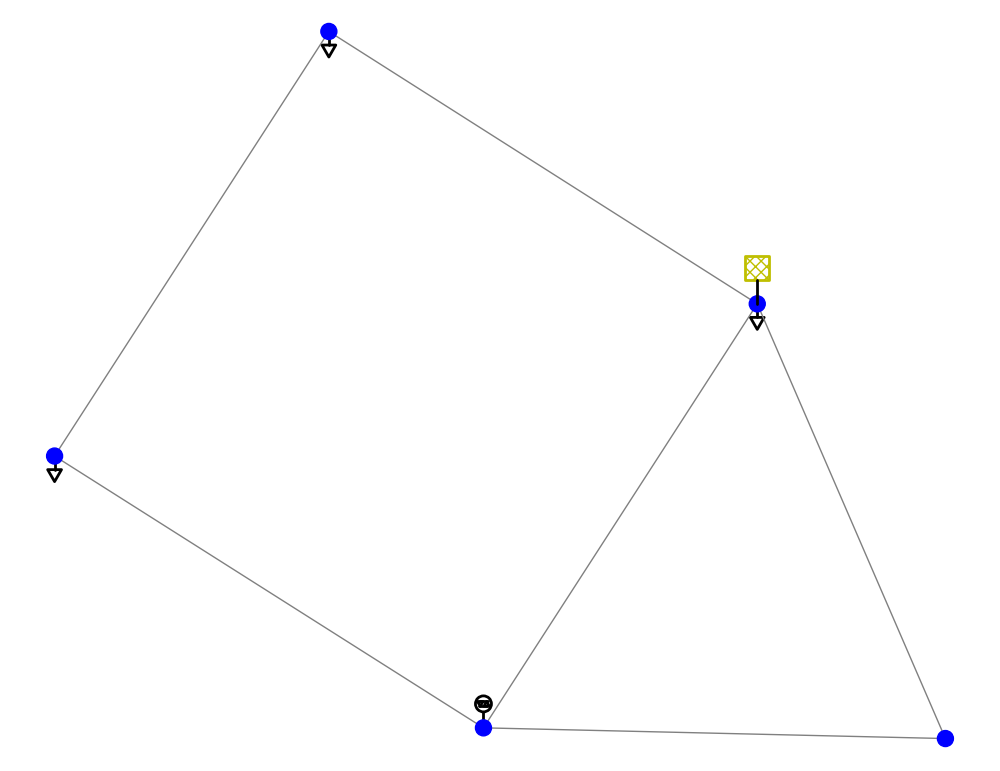

In [3]:
# simple plot
net = ppn.case5()
pp.plotting.simple_plot(net, plot_loads=True, plot_sgens=True)
plt.show()

C:\Users\kr8938\Anaconda3\lib\site-packages\pandapower\auxiliary.py:272: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item, dtype in list(dtypes.iteritems()):
C:\Users\kr8938\Anaconda3\lib\site-packages\pandapower\auxiliary.py:272: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item, dtype in list(dtypes.iteritems()):
C:\Users\kr8938\Anaconda3\lib\site-packages\pandapower\auxiliary.py:272: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item, dtype in list(dtypes.iteritems()):
C:\Users\kr8938\Anaconda3\lib\site-packages\pandapower\auxiliary.py:272: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item, dtype in list(dtypes.iteritems()):
C:\Users\kr8938\Anaconda3\lib\site-packages\pandapower\auxiliary.py:272: FutureWarning: iteritems is deprecated and will

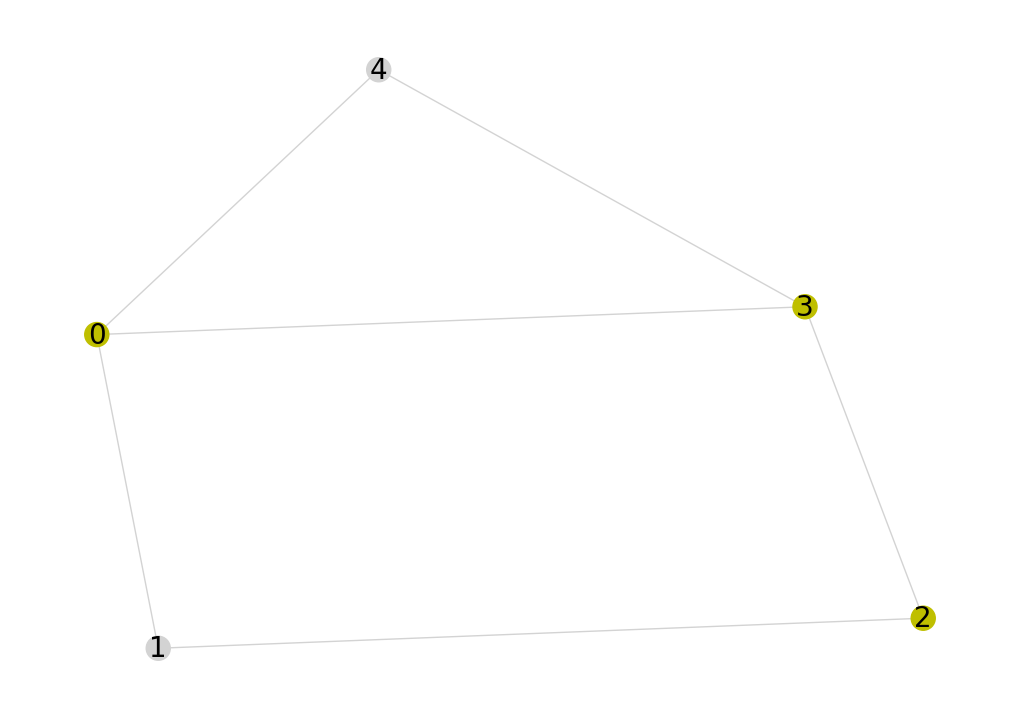

In [4]:
# networkx
mat = ppc.from_mpc('casefiles/case5.mat')
net = pp.topology.create_nxgraph(mat)

# generators in yellow
bus_color = np.full(len(mat.bus), 'lightgray')
bus_color[mat.gen.bus] = 'y'

# create coordinates
coord = {0: (1,2), 1: (2,2), 2: (3,2), 3: (3,1), 4: (1,1)}
nx.set_node_attributes(net, coord, 'coord')

plt.figure(figsize=(10,7)) 
nx.draw(net, node_color=bus_color, with_labels=True, font_size=20, edge_color='lightgray', font_color='k')

### Data

In [10]:
def extract_results(mat_file, kind, t=6, mean_var="mean"):
    assert kind in mat_file.keys(), "Wrong kind."
    d = mat_file[kind][mean_var]
    return {int(bus.split("_")[1]) : ts[t] for bus, ts in d.items()}

## Functions

In [11]:
def plot_graph(case, coord, nr_unc_stor, stor, var, loc_glob, t, case_nr='case5', figsize=(10,5), SHOW_NRS=True, LAB=True):
    
    plt.rcParams['text.usetex'] = True
    
    opf_results = mat73.loadmat('Results/Paper1_Journal_allcases/case'+case+'/'+nr_unc_stor+'/ExportedResults/Results_DCsOPF_'+stor+'_'+loc_glob+var+'.mat')

    # graph
    pp_case = ppc.from_mpc('casefiles/'+case_nr+'.mat')
    G_ = pp.topology.create_nxgraph(pp_case)
    
    G = nx.Graph()
    G.add_nodes_from(sorted(G_.nodes(data=True)))
    G.add_edges_from(G_.edges(data=True))
    
    # nrs
    nr_buses = len(pp_case.bus)

    # unc & stor
    uncertainties = opf_results['uncertainties'].tolist()
    uncertainties = uncertainties if type(uncertainties)!=int else [uncertainties]
    storages = extract_results(opf_results, 'storages', 6) if 'storages' in opf_results.keys() else []
    max_gen = [pp_case.gen.max_p_mw[i] if i in pp_case.gen.bus else 0 for i in range(nr_buses)]

    # results
    results_gen_ = extract_results(opf_results, 'generators', t)
    results_gen = [results_gen_[i] if i in results_gen_.keys() else 0 for i in range(1,len(G.nodes())+1)]
    results_loads_ = extract_results(opf_results, 'load', t, 'mean')
    results_loads = [-results_loads_[i] if (i in results_loads_.keys() and results_loads_[i] < 0) else 0 for i in range(1,len(G.nodes())+1)]
    results_wind = [results_loads_[i] if (i in results_loads_.keys() and results_loads_[i] > 0) else 0 for i in range(1,len(G.nodes())+1)]
    results_lines_ = extract_results(opf_results, 'lines', t)
    results_lines = [results_lines_[i] if i in results_lines_.keys() else 0 for i in range(1,len(G.edges())+1)]
    if stor == 'Storage':
        results_storages_ = extract_results(opf_results, 'storages', t)
        results_storages = [results_storages_[i] if i in results_storages_.keys() else 0 for i in range(1,len(G.nodes())+1)]
    
    # edge labels
    edge_labels = {list(G.edges())[i] : '$<$ '+str(np.abs(l)) if l<0 else str(np.abs(l))+' $>$' for i,l in enumerate(np.round(results_lines,2))}
    
    # modify indices (Julia to Python)
    uncertainties = [u-1 for u in uncertainties]
    storages = [s-1 for s in storages]

    factor = 170
    offset = 0.05
    coord_labels = {k:(v[0]+offset,v[1]+offset) for k,v in coord.items()}
    offset_stor = 0.08
    coord_stor = {k:(v[0]-offset_stor,v[1]) for k,v in coord.items()}    
    offset_wind = 0.05
    coord_wind = {k:(v[0]-offset_wind-0.04,v[1]+offset_wind+0.02) for k,v in coord.items()}
    coord_wind_gen = {k:(v[0]-offset_wind,v[1]) for k,v in coord.items()}
    offset_stor_lab = 0.12
    coord_stor_lab = {k:(v[0]-offset_stor_lab,v[1]-offset_stor_lab) for k,v in coord.items()}
    labels = {k:k+1 for k,v in coord.items()}
    max_gen_color = ['blue' if e!=0 else 'blue' for e in max_gen]
    unc_sizes_gen = [650 if i in uncertainties else 0 for i,e in enumerate(results_gen) ]
    if stor=='Storage':
        sizes_stor = [500 if i in storages else 0 for i,e in enumerate(results_storages) ]
    col='gray'

    plt.figure(figsize=figsize)
    nx.draw(G, coord, with_labels=False, font_size=10, node_size=1, node_color=col, edge_color='white', font_color='k')
    if LAB:
        nx.draw_networkx_labels(G, coord_labels, labels=labels, font_color='k', font_size=20)
    if stor=='Storage':
        nx.draw_networkx_nodes(G, coord, node_color='y', node_size=np.multiply(results_storages,170), node_shape='o') # storage
        nx.draw_networkx_nodes(G, coord_stor, node_color='olive', node_size=sizes_stor, node_shape='$stor$') # unc gen
    nx.draw_networkx_nodes(G, coord_wind, node_color='blue', node_size=unc_sizes_gen, node_shape='$wind$') # unc gen
    nx.draw_networkx_nodes(G, coord, node_color='red', node_size=np.multiply(results_loads,factor), node_shape=11) # 8 = triangle left
    nx.draw_networkx_nodes(G, coord, node_color='blue', node_size=np.multiply(results_wind,factor), node_shape=10) # 8 = triangle left
    nx.draw_networkx_nodes(G, coord, node_color='lightblue', node_size=np.multiply(results_gen,factor), node_shape=10) # 9 = triangle right
    nx.draw_networkx_edges(G, coord, edge_color=col, width=np.multiply(results_lines,1))
    if SHOW_NRS:
        nx.draw_networkx_edge_labels(G, coord, edge_labels = edge_labels, font_color = col, font_size=20)

    plt.margins(0.15)
    plt.savefig('graphics/MATLAB_runopf_results/case'+case+'_'+stor+'_'+nr_unc_stor+'_allInOne_Graph_diff_t='+str(t)+'.png')
    plt.show()

In [6]:
def plot_graph_diff_stor(case, coord, nr_unc_stor, var, loc_glob, t, case_nr='case5', figsize=(10,5), SHOW_NRS=True):
    
    plt.rcParams['text.usetex'] = True
    
    opf_results = mat73.loadmat('Results/Paper1_Journal_allcases/case'+case+'/'+nr_unc_stor+'/ExportedResults/Results_DCsOPF_NoStorage_'+loc_glob+var+'.mat')
    opf_results_stor = mat73.loadmat('Results/Paper1_Journal_allcases/case'+case+'/'+nr_unc_stor+'/ExportedResults/Results_DCsOPF_Storage_'+loc_glob+var+'.mat')

    # graph
    pp_case = ppc.from_mpc('casefiles/'+case_nr+'.mat')
    G_ = pp.topology.create_nxgraph(pp_case)
    
    G = nx.Graph()
    G.add_nodes_from(sorted(G_.nodes(data=True)))
    G.add_edges_from(G_.edges(data=True))
    
    # nrs
    nr_buses = len(pp_case.bus)

    # unc & stor
    uncertainties = opf_results_stor['uncertainties'].tolist()
    uncertainties = uncertainties if type(uncertainties)!=int else [uncertainties]
    storages = extract_results(opf_results_stor, 'storages', 6) if 'storages' in opf_results_stor.keys() else []
    max_gen = [pp_case.gen.max_p_mw[i] if i in pp_case.gen.bus else 0 for i in range(nr_buses)]

    # results
    results_gen_ = extract_results(opf_results_stor, 'generators', t)
    results_gen = [results_gen_[i] if i in results_gen_.keys() else 0 for i in range(1,len(G.nodes())+1)]
    results_loads_ = extract_results(opf_results_stor, 'load', t, 'mean')
    results_loads = [-results_loads_[i] if i in results_loads_.keys() else 0 for i in range(1,len(G.nodes())+1)]
    results_lines_ = extract_results(opf_results, 'lines', t)
    results_lines = [results_lines_[i] if i in results_lines_.keys() else 0 for i in range(1,len(G.edges())+1)]
    results_lines_stor_ = extract_results(opf_results_stor, 'lines', t)
    results_lines_stor = [results_lines_stor_[i] if i in results_lines_stor_.keys() else 0 for i in range(1,len(G.edges())+1)]
    results_storages_stor_ = extract_results(opf_results_stor, 'storages', t)
    results_storages_stor = [results_storages_stor_[i] if i in results_storages_stor_.keys() else 0 for i in range(1,len(G.nodes())+1)]

    # edge labels
    edge_labels = {list(G.edges())[i] : '$<$ '+str(np.abs(l)) if l<0 else str(np.abs(l))+' $>$' for i,l in enumerate(np.round(results_lines,2))}
    edge_color = ['green' if np.abs(l2)>np.abs(l1) else 'orange' for i,(l1,l2) in enumerate(zip(np.round(results_lines,2),np.round(results_lines_stor,2)))]
    load_color = ['darkred' if g in uncertainties else 'red' for g in range(1,len(results_loads)+1) ]
    
    # modify indices (Julia to Python)
    uncertainties = [u-1 for u in uncertainties]
    storages = [s-1 for s in storages]

    factor = 170
    offset = 0.05
    coord_labels = {k:(v[0]+offset,v[1]+offset) for k,v in coord.items()}
    offset_stor = 0.05
    coord_stor = {k:(v[0]-offset_stor,v[1]) for k,v in coord.items()}
    offset_wind = 0.05
    coord_wind = {k:(v[0]+offset_wind,v[1]-offset_wind) for k,v in coord.items()}
    offset_gen = 0.05
    coord_gen = {k:(v[0]+offset_gen,v[1]) for k,v in coord.items()}
    labels = {k:k+1 for k,v in coord.items()}
    max_gen_color = ['blue' if e!=0 else 'blue' for e in max_gen]
    unc_sizes_gen = [200 if i in uncertainties else 0 for i,e in enumerate(results_gen) ]
    unc_sizes_load = [e*factor*1.7 if i in uncertainties else e*factor for i,e in enumerate(results_loads) ]
    sizes_stor = [200 if i in storages else 0 for i in G.nodes() ]

    plt.figure(figsize=figsize)
    nx.draw(G, coord, with_labels=False, font_size=10, node_size=1, node_color='purple', edge_color='lightgray', font_color='k')
    nx.draw_networkx_labels(G, coord_labels, labels=labels, font_color='k', font_size=20)
    #nx.draw_networkx_nodes(G, coord, node_color='darkred', node_size=unc_sizes_load, node_shape=11) # unc load
    nx.draw_networkx_nodes(G, coord, node_color=load_color, node_size=np.multiply(results_loads,factor), node_shape=10) # load
    nx.draw_networkx_nodes(G, coord_wind, node_color='blue', node_size=unc_sizes_gen, node_shape='$w$') # unc gen
    nx.draw_networkx_nodes(G, coord_gen, node_color=max_gen_color, node_size=np.multiply(results_gen,factor), node_shape=10) # gen
    nx.draw_networkx_nodes(G, coord_stor, node_color='green', node_size=np.multiply(results_storages_stor,factor), node_shape=10) # 8 = triangle left
    nx.draw_networkx_edges(G, coord, edge_color=edge_color, width=np.multiply(results_lines,1))
    if SHOW_NRS:
        nx.draw_networkx_edge_labels(G, coord, edge_labels = edge_labels, font_color = 'purple', font_size=20)

    plt.margins(0.15)
    plt.savefig('graphics/MATLAB_runopf_results/case'+case+'_'+nr_unc_stor+'_allInOne_Graph_diff_t='+str(t)+'.png')
    plt.show()
    


### case5

In [12]:
t=2

In [13]:
case = '39_volatile'
nr_unc_stor = '1+1'
stor = 'NoStorage'
var = '' # '_WithVariance'
loc_glob = 'local'
opf_results = mat73.loadmat('Results/Paper1_Journal_allcases/case'+case+'/'+nr_unc_stor+'/ExportedResults/Results_DCsOPF_'+stor+'_'+loc_glob+var+'.mat')

extract_results(opf_results, 'generators', t=t)

case5_coord = {0: (1,2), 1: (2,2), 2: (3,2), 3: (3,1), 4: (1,1)}

extract_results(opf_results, 'lines', t=t)

{1: 1.7158415155313214,
 10: -5.063193980783494,
 11: 1.8288515221667343,
 12: 3.295487057848154,
 13: -2.266168740768605,
 14: -6.0925122978630455,
 15: 0.7236870578481498,
 16: -3.189461419985112,
 17: -3.2609614199851102,
 18: 2.3849693254884334,
 19: 3.8481251733601303,
 2: -2.7894415155313212,
 20: -6.2330944988485655,
 21: -0.1188005847198222,
 22: 0.024970584719822345,
 23: 3.8730957580799528,
 24: 1.7229690765157253,
 25: -1.797030923484272,
 26: 2.178761244787775,
 27: -4.31396404779319,
 28: -3.095432372669919,
 29: -0.1853957478089355,
 3: 4.999999998433737,
 30: 0.39553086138527926,
 31: 1.7832303834024905,
 32: 1.8920000077345778,
 33: -6.205964055527766,
 34: -5.5879999922654235,
 35: -6.10943237266992,
 36: 0.09653168364969743,
 37: -6.205964056319617,
 38: 3.5799957478089426,
 39: -6.205964064159245,
 4: 0.9250954670313245,
 40: 2.903446987894005,
 41: -4.442351520862688,
 42: 1.3077696165975083,
 43: 0.3070714856482515,
 44: -0.24039411435174873,
 45: -1.95892851435174

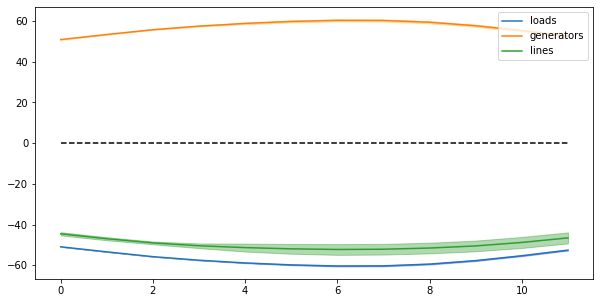

Sum of load:  -52.5783779802073
Sum of gen:  52.57837797826756
=> Gen = load :  False

Sum var of load:  -52.5783779802073
Sum var of gen:  52.57837797826756
Sum var of lines:  -46.57344060769928
=> Sum of variance of -load+gen =? lines :  False


In [13]:
times = range(12)

mean_load = np.array([np.sum(list(extract_results(opf_results, 'load', t, "mean").values())) for t in times])
mean_gen = np.array([np.sum(list(extract_results(opf_results, 'generators', t, "mean").values())) for t in times])
mean_lines = np.array([np.sum(list(extract_results(opf_results, 'lines', t, "mean").values())) for t in times])

var_load = np.array([np.sum(np.sqrt(np.array(list(extract_results(opf_results, 'load', t, "var").values())))) for t in times])
var_gen = np.array([np.sum(np.sqrt(np.array(list(extract_results(opf_results, 'generators', t, "var").values())))) for t in times])
var_lines = np.array([np.sum(np.sqrt(np.array(list(extract_results(opf_results, 'lines', t, "var").values())))) for t in times])

# mean
plt.figure(figsize=(10,5))
plt.plot(mean_load, label="loads")
plt.plot(mean_gen, label="generators")
plt.plot(mean_lines, label="lines")
plt.plot(np.full(12,0), c='k', ls='dashed')

# variance
plt.fill_between(times, mean_load + var_load, mean_load - var_load, alpha = 0.3, color='blue')
plt.fill_between(times, mean_gen + var_gen, mean_gen - var_gen, alpha = 0.3, color='orange')
plt.fill_between(times, mean_lines + var_lines, mean_lines - var_lines, alpha = 0.3, color='green')

plt.legend()
plt.show()

time = 11
res_load = extract_results(opf_results, 'load', time).values()
print("Sum of load: ", np.sum(list(res_load)))
res_gen = extract_results(opf_results, 'generators', time).values()
print("Sum of gen: ", np.sum(list(res_gen)))
#res_line = extract_results(opf_results, 'lines', time).values()
#print("Sum of lines: ", np.sum(list(res_line)))

print("=> Gen = load : ", -np.sum(list(res_load)) == np.sum(list(res_gen)))

var_load = extract_results(opf_results, 'load', time).values()
print("\nSum var of load: ", np.sum(list(var_load)))
var_gen = extract_results(opf_results, 'generators', time).values()
print("Sum var of gen: ", np.sum(list(var_gen)))
var_line = extract_results(opf_results, 'lines', time).values()
print("Sum var of lines: ", np.sum(list(var_line)))

print("=> Sum of variance of -load+gen =? lines : ", -np.sum(list(var_load)) + np.sum(list(var_gen)) == np.sum(list(var_line)))

In [14]:
t=0
plot_graph('5_artificial', case5_coord, "1+1", 'NoStorage', var, loc_glob, t=t, case_nr='case5_artificial')
plot_graph('5_artificial', case5_coord, "1+1", 'Storage', var, loc_glob, t=t, case_nr='case5_artificial')

C:\Users\kr8938\Anaconda3\lib\site-packages\pandapower\auxiliary.py:272: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item, dtype in list(dtypes.iteritems()):
C:\Users\kr8938\Anaconda3\lib\site-packages\pandapower\auxiliary.py:272: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item, dtype in list(dtypes.iteritems()):
C:\Users\kr8938\Anaconda3\lib\site-packages\pandapower\auxiliary.py:272: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item, dtype in list(dtypes.iteritems()):
C:\Users\kr8938\Anaconda3\lib\site-packages\pandapower\auxiliary.py:272: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item, dtype in list(dtypes.iteritems()):
C:\Users\kr8938\Anaconda3\lib\site-packages\pandapower\auxiliary.py:272: FutureWarning: iteritems is deprecated and will

TypeError: '_AxesStack' object is not callable

<Figure size 1000x500 with 0 Axes>

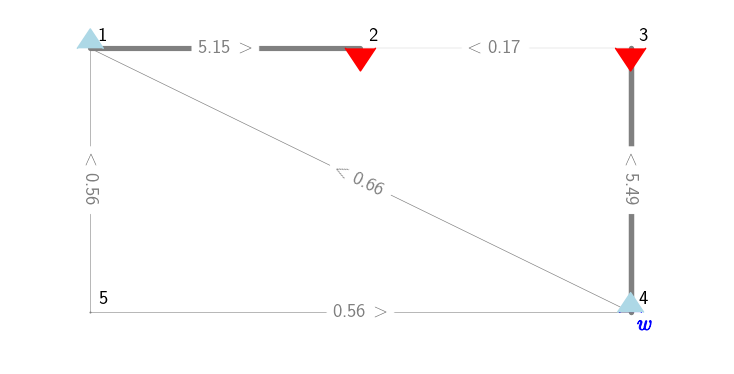

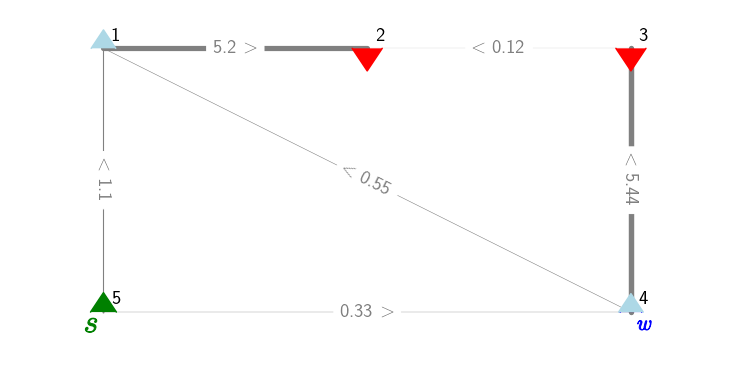

In [141]:
t=7
plot_graph('5_artificial', case5_coord, "1+1", 'NoStorage', var, loc_glob, t=t, case_nr='case5_artificial')
plot_graph('5_artificial', case5_coord, "1+1", 'Storage', var, loc_glob, t=t, case_nr='case5_artificial')

In [6]:
opf_results = mat73.loadmat('Results/case39_volatile/7+5/ExportedResults/Results_DCsOPF_NoStorage_local.mat')
#for k,v in extract_results(opf_results, 'lines', 8).items():
#    print('<pen name="my_width3_'+str(k)+'" value="'+str(np.round(np.abs(v),2))+'"/>')
extract_results(opf_results, 'load', 8)

{1: -1.1450481588187222,
 12: -0.1000743933885625,
 15: -3.754256258422041,
 16: 4.564870534635276,
 18: -1.8536640275958827,
 20: 3.4624198395151486,
 21: 3.859984108337214,
 23: -2.9036825748732973,
 24: -3.6205108792157557,
 25: -2.627979380895429,
 26: 1.9339411974138763,
 27: 1.5808554533899504,
 28: -2.4168024663591887,
 29: -3.3260364039457766,
 3: -3.7777203600371787,
 31: -0.10793486742963367,
 39: -12.952184091556038,
 4: 1.4553637567534703,
 7: -2.7429534788096035,
 8: 0.7061288711693949,
 9: -0.0762583302491977}

In [14]:
opf_results = mat73.loadmat('Results/caseTurkish/20+14/ExportedResults/Results_DCsOPF_NoStorage_local.mat')
#for k,v in extract_results(opf_results, 'lines', 8).items():
#    print('<pen name="my_width3_'+str(k)+'" value="'+str(np.round(np.abs(v),2))+'"/>')
np.sum([e for e in list(extract_results(opf_results, 'load', 8).values()) if e < 0]), np.sum([e for e in list(extract_results(opf_results, 'load', 8).values()) if e > 0])

(-84.46520749800843, 47.50085649696373)

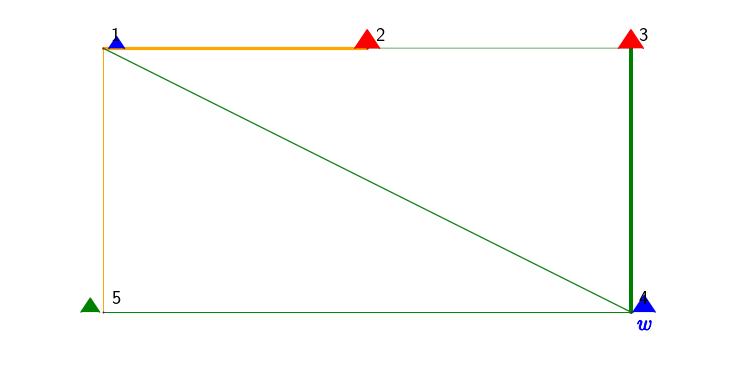

In [13]:
t=0
plot_graph_diff_stor('5_inv_newCaseFile', case5_coord, "1+1", var, loc_glob, t=t, case_nr='case5_new', SHOW_NRS=False)

In [17]:
def plot_network_limits_RESULTS_FROM_JULIA(mat_file='results_caseTurkish_dataset_mpc', file_directory='caseTurkish_distributedStorages', DCsOPF_file='Results_DCsOPF_NoStorage_global'):

    baseMVA = 100
    t = 6
    
    # capacities
    df            = data['capacity source type (MW)']
    
    # .mat file
    mat           = scipy.io.loadmat('casefiles/'+mat_file+'.mat')
    mat_results   = mat73.loadmat('graphics/DCsOPF_results/Turkish_firstPaperDraft/'+file_directory+"/"+DCsOPF_file+'.mat')
    uncertainties = mat_results['uncertainties']
    if 'storages' in mat_results.keys():
        storages = extract_Pg_time_t(mat_results['storages']['mean'], 6, 100)[:,0].astype(int)
    else:
        storages = []
    
    # graph
    case = ppc.from_mpc('casefiles/'+mat_file+'.mat')
    G    = pp.topology.create_nxgraph(case)
    
    # buses, generators and branches
    mat_bus         = mat['mpc'][0][0][2]
    # mat_gen         = mat['mpc'][0][0][3]
    mat_branch      = mat['mpc'][0][0][4]
    mat_results_gen = mat_results['generators']['mean'] # new
    
    # relabel indices
    # MATLAB (starts counting at 1) --> Python (starts counting at 0)
    uncertainties       = [u-1 for u in uncertainties]
    storages            = [s-1 for s in storages]
    mat_bus[:,0]        = mat_bus[:,0].astype(int)-1
    mat_gen[:,0]        = mat_gen[:,0].astype(int)-1
    mat_branch[:,[0,1]] = mat_branch[:,[0,1]].astype(int)-1 
    
    # ------------ LABELS (node names & nrs) --------------------
    G_nrs = G.copy()
    labels_nrs = {n : n for n in list(G.nodes)}
    G_nrs = nx.relabel_nodes(G_nrs, labels_nrs)
    labels_name = {n : bus_nr_to_dataset_names([n+1])[0] for n in list(G.nodes)}
    G = nx.relabel_nodes(G, labels_name)
    labels_nrs = {n : list(G_nrs.nodes)[i] for i,n in enumerate(list(G.nodes))}

    # ------------ COORDINATES --------------------
    # coordinates (names)
    coordinates_case = dict()
    for n in G.nodes:
        idx = df[df['Substation Nodes']==n].index[0]
        coordinates_case[n] = df.loc[idx, 'Longitude'], df.loc[idx, 'Latitude']
    coordinates_case = {e: coordinates_case[e] for e in list(np.unique(list(coordinates_case.keys())))}
    nx.set_node_attributes(G, coordinates_case, 'coord')
    
    # coordinates (numbers)
    coordinates_case_nrs = dict()
    for n in G_nrs.nodes:
        coordinates_case_nrs[n] = df.loc[n, 'Longitude'], df.loc[n, 'Latitude']
    coordinates_case_nrs = {e: coordinates_case_nrs[e] for e in list(np.unique(list(coordinates_case_nrs.keys())))}
    nx.set_node_attributes(G_nrs, coordinates_case_nrs, 'coord')

    # ------------ LOADS --------------------
    #loads = mat_bus[:,2]
    loads = extract_Pg_time_t(mat_results['load'], t, baseMVA)[:,1] * (-1)
    loads_labels = {name : loads[nr].astype(int) for name,nr in zip(list(G.nodes), list(G_nrs.nodes))}
    node_size_loads = list(loads_labels.values())
    pos_labels = {k : (v[0]+0.2,v[1]+0.2) for k,v in coordinates_case.items()}
    pos_labels_nrs = {k : (v[0]-0.2,v[1]-0.2) for k,v in coordinates_case.items()}
    
    # ------------ GENERATION --------------------
    
    # generation
    gen = np.zeros(len(mat_bus))
    #gen[mat_gen[:,0].astype(int)] = mat_gen[:,1]
    gen_bus_nrs = extract_Pg_time_t(mat_results_gen, t, baseMVA)[:,0].astype(int) - 1 # JULIA -> PYTHON
    gen[gen_bus_nrs] = extract_Pg_time_t(mat_results_gen, t, baseMVA)[:,1]
    gen_labels = {nr : gen[nr] for nr in list(G_nrs.nodes)}
    node_size_gen = list(gen_labels.values())
    
    # max gen
    color1, color2 = 'orange', 'darkorange'
    #gen_abs = mat_gen[:,1]
    gen_abs = extract_Pg_time_t(mat_results_gen, t, baseMVA)[:,1]
    gen_cap = mat_gen[:,8]
    max_gen = []
    j = 0
    for i in range(len(mat_bus)):
        if i in mat_gen[:,0].astype(int):
            if gen_abs[j] > gen_cap[j]*0.98:
                max_gen.append(color2)
            else:
                max_gen.append(color1)
            j = j+1
        else:
            max_gen.append(color1)
    max_gen

    # ------------ LINE FLOWs & CAPACITIES --------------------
    G_lines = nx.Graph()
    G_lines.add_nodes_from(G.nodes)
    
    # line flow
    c = 0.03
    mat_buses = mat_branch
    #line_flow = mat_buses[:,15]*c # flow fbus to tbus
    line_flow = abs(extract_Pg_time_t(mat_results['lines']['mean'], t)[:,1])
    for i,e in enumerate(G.edges):
        G_lines.add_edge(e[0],e[1],weight=line_flow[i])
        
    # line capacities
    rateA = mat_branch[:,5] # rate A
    max_flow_ = [line_flow[i] > rateA[i]*0.98 for i in range(len(rateA))]
    max_flow = ['midnightblue' if e else 'royalblue' for e in max_flow_]
    
    # ------------ STORAGES & UNCERTAINTIES --------------------
    uncertainty_labels = DF(np.zeros(len(mat_bus)), index=list(G_nrs.nodes),columns=['0'])
    uncertainty_labels.loc[uncertainties] = 100
    storage_labels = DF(np.zeros(len(mat_bus)), index=list(G_nrs.nodes),columns=['0'])
    storage_labels.loc[storages] = 200

    # ============== PLOT ======================================
    a = 1.5
    plt.figure(figsize=(23,12)) 
    nx.draw(G, coordinates_case, node_color='white', with_labels=False, font_size=10, edge_color='white', font_color='k', node_size=1)
    # labels
    #nx.draw_networkx_labels(G, pos_labels, labels=loads_labels, font_color='gray', font_size=20)
    #nx.draw_networkx_labels(G, pos_labels_nrs, labels=labels_nrs)
    # edges
    nx.draw_networkx_edges(G, coordinates_case, node_size=0, edge_color='lightsteelblue', width=rateA*c, alpha=0.7)
    nx.draw_networkx_edges(G, coordinates_case, edge_color=max_flow, width=line_flow * c, alpha=0.7)
    # nodes
    nx.draw_networkx_nodes(G, coordinates_case, node_color='khaki', node_size=np.multiply(node_size_loads,a), node_shape=8) # 8 = triangle left
    nx.draw_networkx_nodes(G, coordinates_case, node_color=max_gen, node_size=np.multiply(node_size_gen,a), node_shape=9) # 9 = triangle right
    nx.draw_networkx_nodes(G, coordinates_case, node_size=np.multiply(storage_labels['0'],a), node_color='mediumaquamarine', node_shape='o')
    nx.draw_networkx_nodes(G, coordinates_case, node_size=uncertainty_labels['0'], node_color='red', node_shape='o') # '$unc.$'
    #plt.title('Matpower results '+name)
    plt.savefig(PATH_SAVE + '/'+file_directory+"_"+DCsOPF_file+'_OPF_results')
    plt.show()

### case39

In [71]:
a, b, c, d, e, f, g, h, i, j = 1, 1.2, 1.4, 1.6, 1.8, 2, 2.2, 2.4, 2.6, 2.8

case39_coord = {
    8:(b,1), 9:(a,2), 39:(a,3), 1:(a,3.3), 2:(a,3.7), 30:(a,4),
    7:(b,1.5), 5:(b,2), 4:(b,2.3), 3:(b,3.2), 25:(b, 3.8), 37:(b,4),
    31:(c,1), 6:(c,2), 
    32:(d,1), 10:(d,1.5), 11:(d,1.7), 12:(d,2), 18:(d,3.2),
    13:(e,2), 14:(e,2.3), 15:(e,2.7), 
    34:(f,1), 20:(f,1.7), 
    19:(g,1.9), 16:(g,3), 17:(g-0.1,3.2), 27:(g,3.5), 26:(g,3.8), 33:(g,1), 
    24:(h,2.3), 
    23:(i,2), 36:(i,1), 28:(i,3.6),
    35:(j,1), 22:(j,1.5), 21:(j,3), 38:(j,3.3), 29:(j,3.8)
}

case39_coord = {k-1:v for k,v in case39_coord.items()}

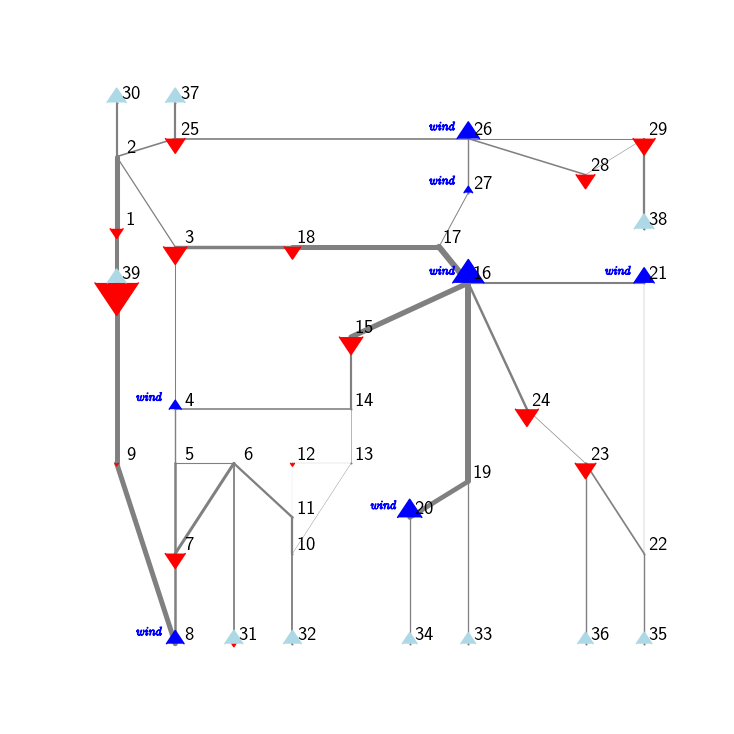

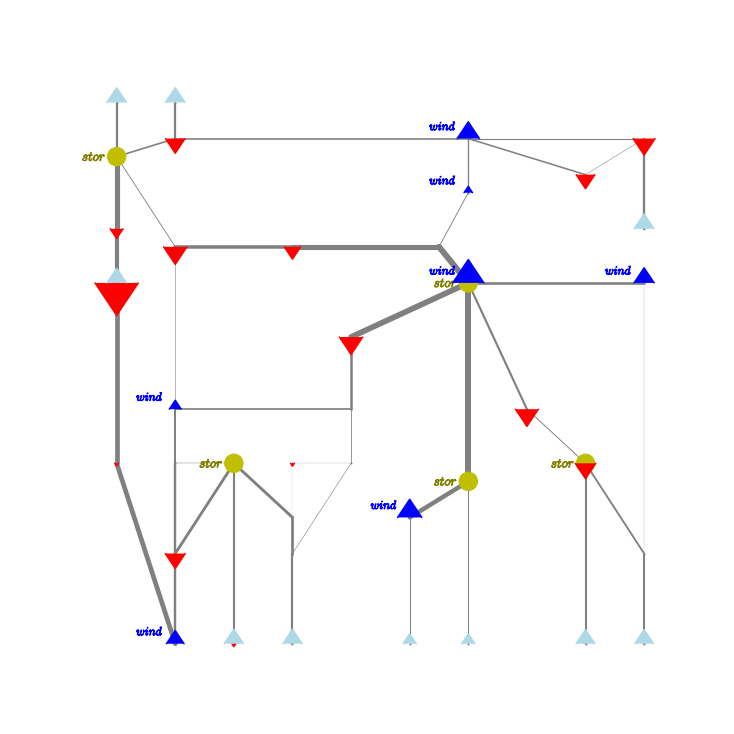

In [231]:
stor = 'Storage'
var = '' # '_WithVariance'
loc_glob = 'local'

t=0
plot_graph('39_volatile', case39_coord, "7+5", 'NoStorage', var, loc_glob, t=t, case_nr='case39', figsize=(10,10), SHOW_NRS=False, LAB=True)
plot_graph('39_volatile', case39_coord, "7+5", 'Storage', var, loc_glob, t=t, case_nr='case39', figsize=(10,10), SHOW_NRS=False, LAB=False)

In [12]:
opf_results['generators']['mean']['bus_33']

KeyError: 'bus_33'

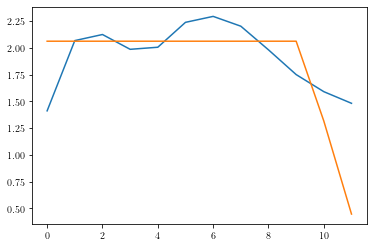

In [246]:
opf_results = mat73.loadmat('Results/case39_volatile/7+5/ExportedResults/Results_DCsOPF_NoStorage_local.mat')
#plt.plot(extract_results(opf_results, 'generators', 5).values())
plt.plot(opf_results['generators']['mean']['bus_36'])
opf_results = mat73.loadmat('Results/case39_volatile/7+5/ExportedResults/Results_DCsOPF_Storage_local.mat')
#plt.plot(extract_results(opf_results, 'generators', 5).values())
plt.plot(opf_results['generators']['mean']['bus_36'])

In [100]:
opf_results['load']['mean']

{'bus_1': array([-0.976     , -1.02652148, -1.0736    , -1.11402724, -1.14504816,
        -1.16454872, -1.1712    , -1.16454872, -1.14504816, -1.11402724,
        -1.0736    , -1.02652148]),
 'bus_12': array([-0.0853    , -0.08971545, -0.09383   , -0.09736324, -0.10007439,
        -0.10177869, -0.10236   , -0.10177869, -0.10007439, -0.09736324,
        -0.09383   , -0.08971545]),
 'bus_15': array([-3.2       , -3.36564419, -3.52      , -3.65254834, -3.75425626,
        -3.81819253, -3.84      , -3.81819253, -3.75425626, -3.65254834,
        -3.52      , -3.36564419]),
 'bus_16': array([5.71199116, 5.717365  , 5.68250732, 5.61674987, 5.17172636,
        4.63370705, 4.34467371, 4.37096389, 4.56487053, 4.7496886 ,
        4.79938904, 4.67904003]),
 'bus_18': array([-1.58      , -1.66178682, -1.738     , -1.80344574, -1.85366403,
        -1.88523256, -1.896     , -1.88523256, -1.85366403, -1.80344574,
        -1.738     , -1.66178682]),
 'bus_20': array([3.45362518, 3.50552753, 4.2415029 ,

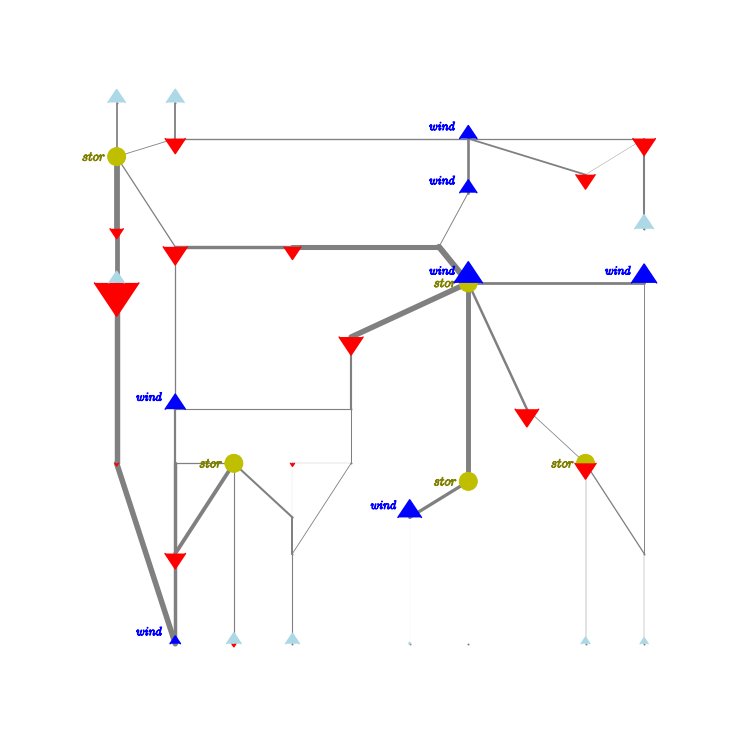

In [253]:
stor = 'Storage'
var = '' # '_WithVariance'
loc_glob = 'local'

t=11
#plot_graph('39_volatile2', case39_coord, "7+5", 'NoStorage', var, loc_glob, t=t, case_nr='case39', figsize=(10,10), SHOW_NRS=False, LAB=True)
plot_graph('39_volatile2', case39_coord, "7+5", 'Storage', var, loc_glob, t=t, case_nr='case39', figsize=(10,10), SHOW_NRS=False, LAB=False)

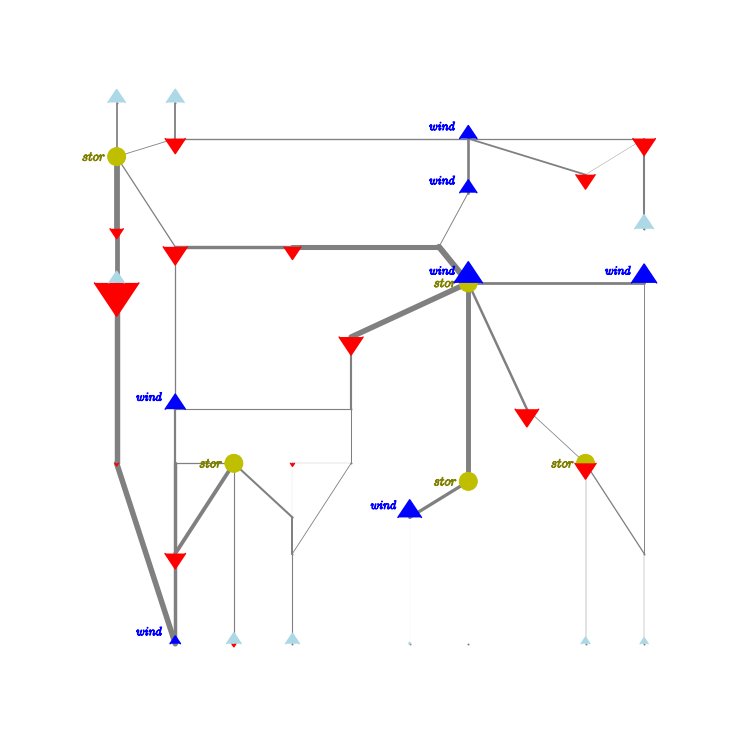

In [252]:
stor = 'Storage'
var = '' # '_WithVariance'
loc_glob = 'local'

t=11
#plot_graph('39_volatile', case39_coord, "7+5", 'NoStorage', var, loc_glob, t=t, case_nr='case39', figsize=(10,10), SHOW_NRS=False, LAB=True)
plot_graph('39_volatile', case39_coord, "7+5", 'Storage', var, loc_glob, t=t, case_nr='case39', figsize=(10,10), SHOW_NRS=False, LAB=False)

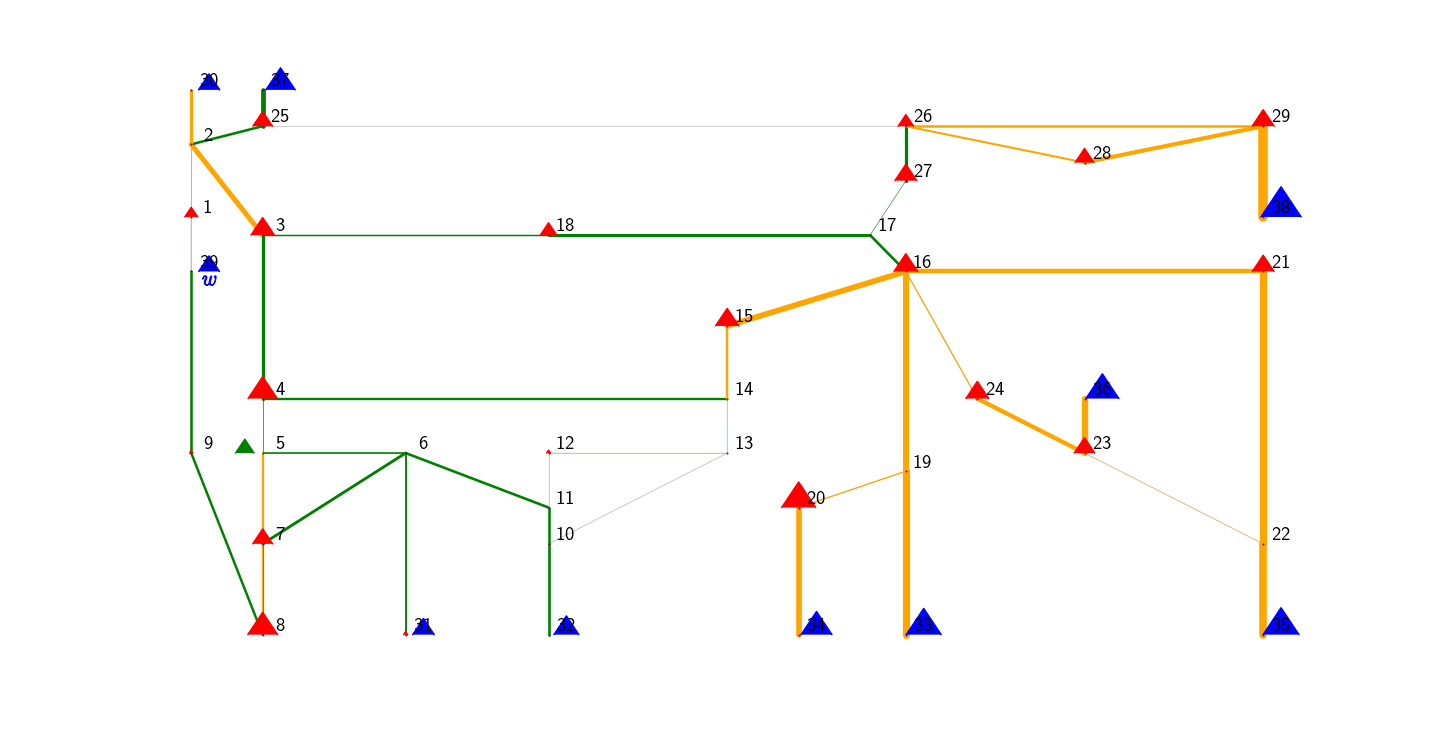

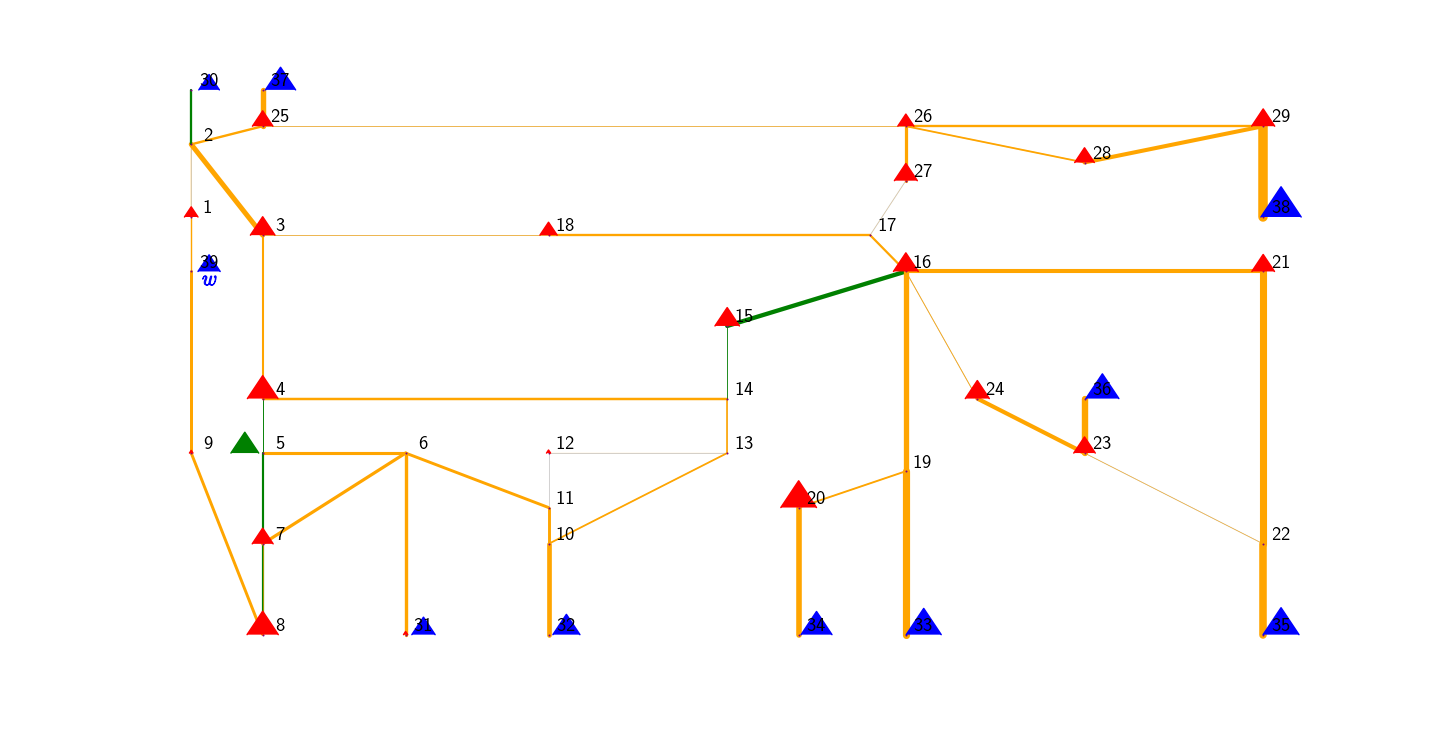

In [18]:
t=0
plot_graph_diff_stor('39_newCov', case39_coord, "1+1", var, loc_glob, t=t, case_nr='case39_v01', figsize=(20,10), SHOW_NRS=False)
t=5
plot_graph_diff_stor('39_newCov', case39_coord, "1+1", var, loc_glob, t=t, case_nr='case39_v01', figsize=(20,10), SHOW_NRS=False)

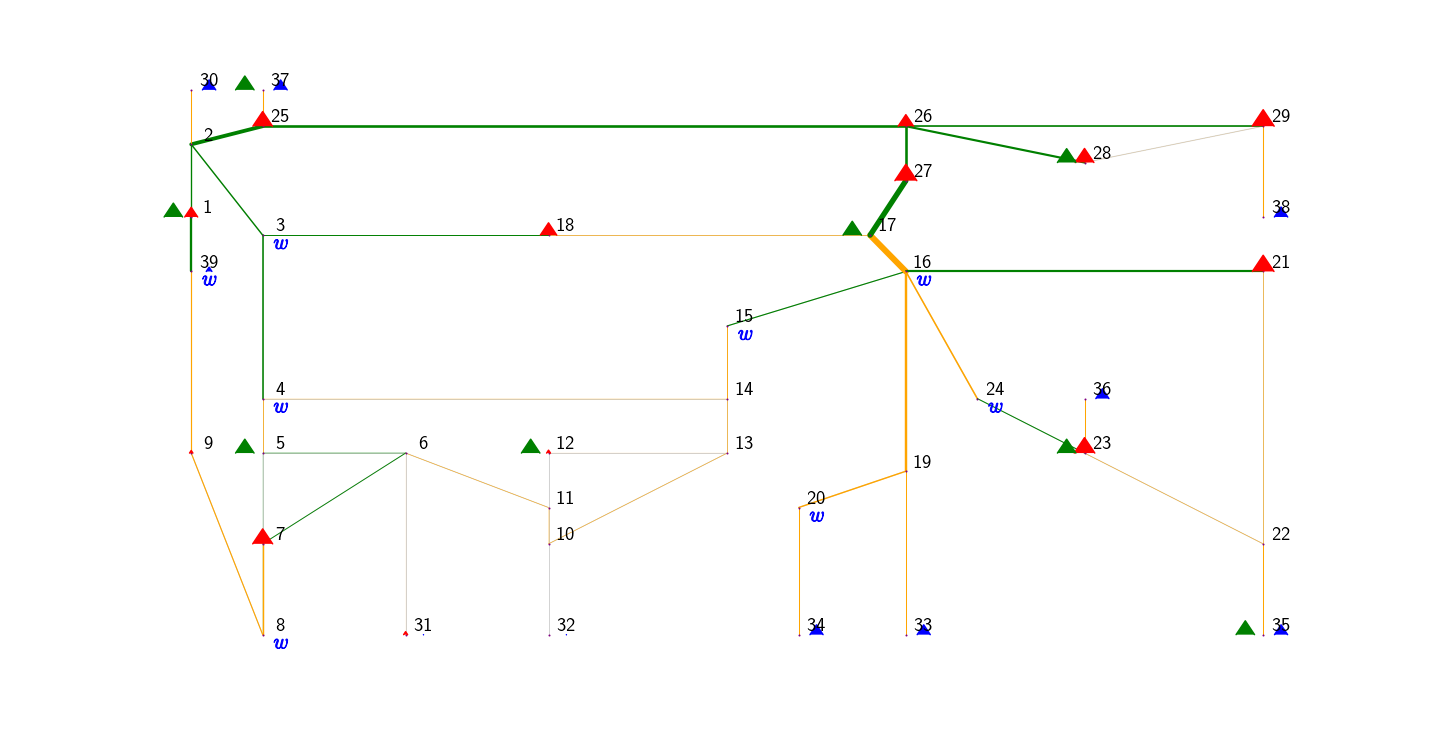

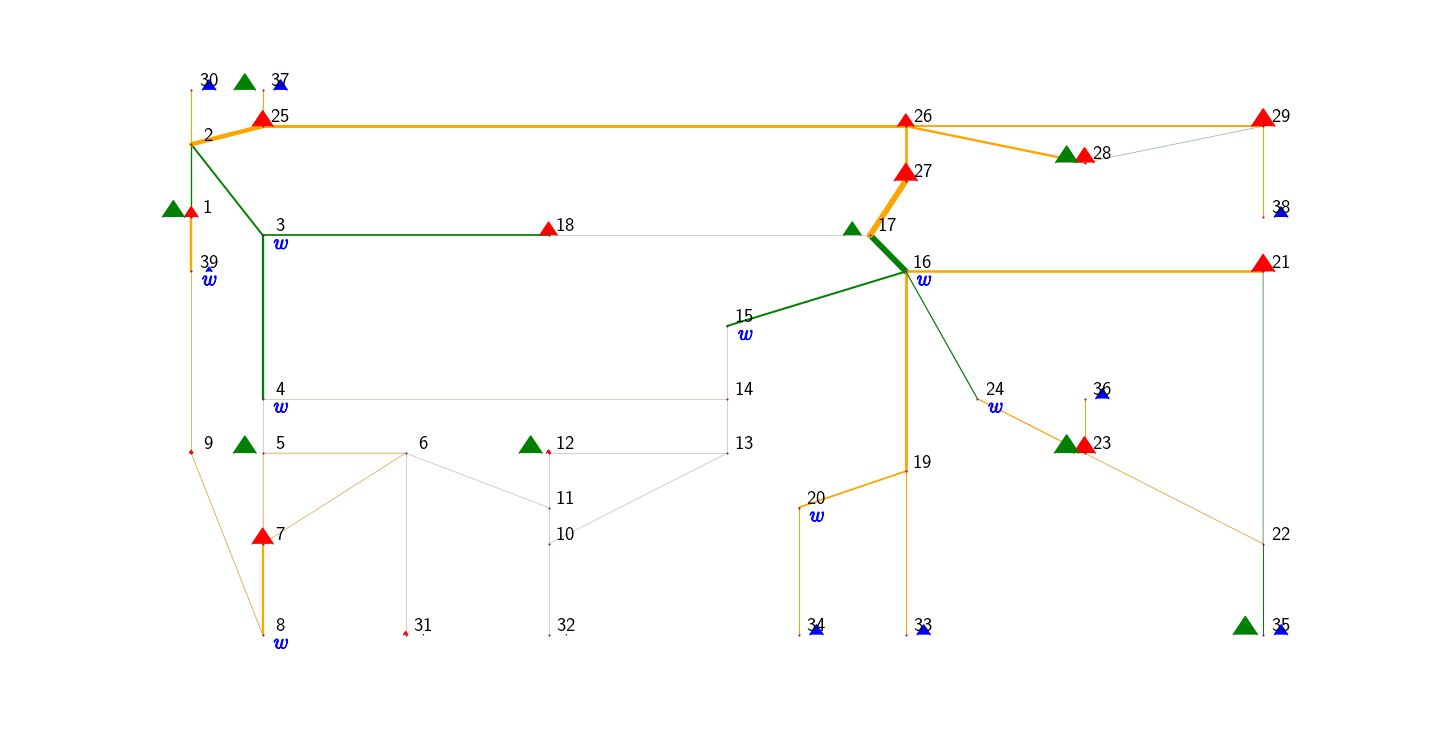

In [19]:
t=0
plot_graph_diff_stor('39_newCov', case39_coord, "8+8", var, loc_glob, t=t, case_nr='case39_v01', figsize=(20,10), SHOW_NRS=False)
t=5
plot_graph_diff_stor('39_newCov', case39_coord, "8+8", var, loc_glob, t=t, case_nr='case39_v01', figsize=(20,10), SHOW_NRS=False)

## Integral

In [912]:
opf_results = mat73.loadmat('Results/case39_newCov/7+5/ExportedResults/Results_DCsOPF_Storage_local.mat')
sum_stor = np.sum([np.sum(list(extract_results(opf_results, 'storages', t, 'var').values())) for t in range(12)])
sum_gen = np.sum([np.sum(list(extract_results(opf_results, 'generators', t, 'var').values())) for t in range(12)])
sum_gen, sum_stor

(12.390007879649609, 12.853771937008915)

In [913]:
opf_results = mat73.loadmat('Results/case39_newCov/7+5/ExportedResults/Results_DCsOPF_NoStorage_local.mat')
sum_gen = np.sum([np.sum(list(extract_results(opf_results, 'generators', t, 'var').values())) for t in range(12)])
sum_gen

15.164380633297114

In [916]:
np.sum([np.sum(list(extract_results(opf_results, 'lines', t, 'var').values())) for t in range(12)])

53.779302224257904

### Turkish

In [18]:
data = pd.read_excel('data/Reduced Turkish Power System.xlsx', header=[0], sheet_name=['capacity source type (MW)', 'transmission lines'])['capacity source type (MW)']

In [19]:
data[['Substation Nodes', 'Latitude', 'Longitude']]

,Substation Nodes,Latitude,Longitude
0,ADANA_Ceyhan,37.031700,35.822750
1,ADANA_Imamoglu,37.258751,35.672840
2,ADANA_Kozan,37.450000,35.800000
3,ADANA_Tufanbeyli,38.264642,36.222398
4,ADANA_Yumurtalik,36.766667,35.783333
...,...,...,...
111,TEKIRDAG_Marmaraereglisi,40.970000,27.955000
112,VAN_Baskale,38.045809,44.015159
113,VAN_Tusba,38.508126,43.367135
114,ZONGULDAK_Eregli,41.289444,31.418056


In [36]:
def create_graph(df, nodes, edges):
    
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)

    # coordinates (longitude/latitude)
    coordinates = {str(nodes[i]) : (df.loc[i, 'Longitude'], df.loc[i, 'Latitude']) for i in df.index}
    nx.set_node_attributes(G, coordinates, 'coord')

    # labels
    labels = {i : str(nodes[i]) for i in df.index}
    G = nx.relabel_nodes(G, labels)
    
    return G, coordinates

In [44]:
# load data
d = pd.read_excel('data/Reduced Turkish Power System.xlsx', header=[0], sheet_name=['capacity source type (MW)', 'transmission lines'])
substations_capacity_coordinates, transmission_lines = d['capacity source type (MW)'], d['transmission lines']
counties_population_coordinates = pd.read_excel('data/Counties Hourly Demand.xlsx', header=[0], sheet_name='population and coordinates')

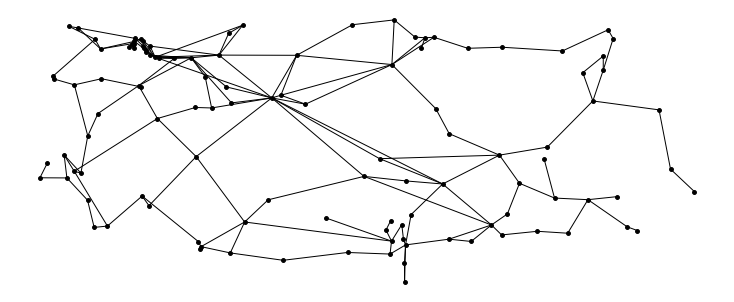

In [50]:
# create graph
df = substations_capacity_coordinates
nodes_substations = df['Substation Nodes']
edges_substations = [(node1, node2) for node1, node2, _ in np.array(transmission_lines)]
G_substations, coord_substations = create_graph(df, nodes_substations, edges_substations)

# plot substations
plt.figure(figsize=fig_size_normal) 
nx.draw(G_substations, coord_substations, node_color='black', node_size=15)
#plt.savefig(PATH_SAVE + '/Turkish_topology_substations.png')
plt.show()

In [51]:
edges_substations

[('ISTANBUL_Eyup', 'KIRKLARELI_Luleburgaz'),
 ('KIRKLARELI_Babaeski', 'KIRKLARELI_Luleburgaz'),
 ('KIRKLARELI_Luleburgaz', 'TEKIRDAG_Marmaraereglisi'),
 ('KIRKLARELI_Babaeski', 'TEKIRDAG_Corlu'),
 ('TEKIRDAG_Corlu', 'CANAKKALE_Gelibolu'),
 ('TEKIRDAG_Corlu', 'TEKIRDAG_Marmaraereglisi'),
 ('TEKIRDAG_Corlu', 'TEKIRDAG_Marmaraereglisi'),
 ('ISTANBUL_Sultangazi', 'TEKIRDAG_Marmaraereglisi'),
 ('ISTANBUL_Basaksehir', 'TEKIRDAG_Marmaraereglisi'),
 ('ISTANBUL_Basaksehir', 'TEKIRDAG_Marmaraereglisi'),
 ('ISTANBUL_Sultangazi', 'ISTANBUL_Basaksehir'),
 ('KOCAELI_Gebze', 'ISTANBUL_Sultangazi'),
 ('ISTANBUL_Sultangazi', 'ISTANBUL_Sariyer'),
 ('ISTANBUL_Basaksehir', 'ISTANBUL_Avcilar'),
 ('ISTANBUL_Esenler', 'ISTANBUL_Basaksehir'),
 ('ISTANBUL_Esenler', 'ISTANBUL_Basaksehir'),
 ('ISTANBUL_Esenler', 'ISTANBUL_Bahcelievler'),
 ('ISTANBUL_Esenler', 'ISTANBUL_Bagcilar'),
 ('ISTANBUL_Eyup', 'ISTANBUL_Beykoz'),
 ('ISTANBUL_Eyup', 'ISTANBUL_Umraniye'),
 ('ISTANBUL_Eyup', 'ISTANBUL_Bagcilar'),
 ('ISTANBUL_

In [47]:
data

,Substation Nodes,Thermal,Hydroelectricity,Wind,Geothermal,Solar,Latitude,Longitude
0,ADANA_Ceyhan,4.74,0.00,0.00,0.0,0.0,37.031700,35.822750
1,ADANA_Imamoglu,60.54,814.97,0.00,0.0,0.0,37.258751,35.672840
2,ADANA_Kozan,0.00,886.29,0.00,0.0,0.0,37.450000,35.800000
3,ADANA_Tufanbeyli,450.00,173.51,0.00,0.0,0.0,38.264642,36.222398
4,ADANA_Yumurtalik,1320.00,0.00,0.00,0.0,0.0,36.766667,35.783333
...,...,...,...,...,...,...,...,...
111,TEKIRDAG_Marmaraereglisi,1002.70,0.00,95.85,0.0,0.0,40.970000,27.955000
112,VAN_Baskale,1.04,47.71,0.00,0.0,0.0,38.045809,44.015159
113,VAN_Tusba,4.80,62.41,0.00,0.0,0.0,38.508126,43.367135
114,ZONGULDAK_Eregli,191.10,0.00,0.00,0.0,0.0,41.289444,31.418056


In [48]:
coord_Turkish = {data['Substation Nodes'][i] : (lon, lat) for i, (lat, lon) in enumerate(np.array(data[['Latitude','Longitude']]))}

In [49]:
coord_Turkish

{'ADANA_Ceyhan': (35.82275, 37.0317),
 'ADANA_Imamoglu': (35.67284, 37.258751),
 'ADANA_Kozan': (35.8, 37.45),
 'ADANA_Tufanbeyli': (36.2223985, 38.2646417),
 'ADANA_Yumurtalik': (35.7833333, 36.7666667),
 'AFYONKARAHISAR_Merkez': (30.54034, 38.76376),
 'AGRI_Merkez': (43.0566667, 39.7216667),
 'AMASYA_Merkez': (35.8333333, 40.65),
 'ANKARA_Kecioren': (32.831015, 40.0210623),
 'ANKARA_Nallihan': (31.359949, 40.191601),
 'ANKARA_Sincan': (32.584229, 39.966751),
 'ANTALYA_Dosemealti': (30.5984143, 37.0229292),
 'ANTALYA_Kepez': (30.672219, 36.918648),
 'ANTALYA_Konyaalti': (30.641946, 36.875598),
 'ANTALYA_Manavgat': (31.46286, 36.790081),
 'ARTVIN_Borcka': (41.68, 41.3625),
 'ARTVIN_Merkez': (41.8166667, 41.1833333),
 'ARTVIN_Yusufeli': (41.5486163, 40.8253871),
 'AYDIN_Germencik': (27.60181, 37.87207),
 'BALIKESIR_Altieylul': (27.885289, 39.646791),
 'BALIKESIR_Bandirma': (27.979227, 40.35946),
 'BATMAN_Merkez': (41.13509, 37.881168),
 'BOLU_Goynuk': (30.7838403, 40.4003841),
 'BURSA_N

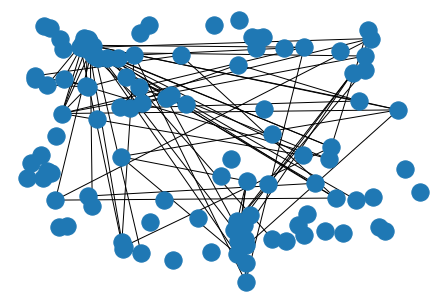

In [65]:
G_test = nx.Graph()
G_test.add_nodes_from(data['Substation Nodes'])
G_test.add_edges_from(l)
nx.draw(G_test, coord_Turkish)

In [57]:
l = [(data['Substation Nodes'][a],data['Substation Nodes'][b]) for (a,b,c) in list(G_.edges)]
l[0] in edges_substations

False

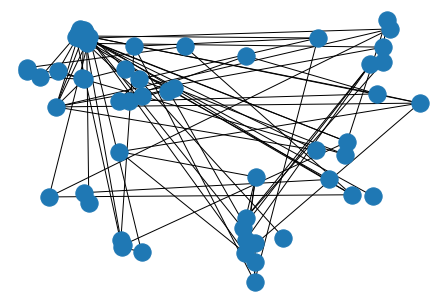

In [23]:
pp_case = ppc.from_mpc('casefiles/caseTurkish_dataset.mat')
G_ = pp.topology.create_nxgraph(pp_case)
G = nx.Graph()
G.add_nodes_from(sorted(G_.nodes(data=True)))
G.add_edges_from(G_.edges(data=True))
nx.draw(G, coord_Turkish, with_labels=False)

[1, 2, 7, 8, 9, 10, 11, 12, 13, 14, 38, 39, 40, 41, 43, 44, 46, 47, 48, 49]
[]
[1.9063075066342052, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.941601393007986, 0, 0, 2.387351957898369, 2.0244352770715626, 1.9378474854478362, 1.9275017278844213, 9.766984846569446e-12, 0, 0.5582242638163352, 0.02017876373379992, 0.333502897323088, 0, 0.5485223078809223, 0.48374310463795506, 0.5485223078806097, 0.6427631745208549, 1.8541792821569802, 1.1698948568168255, 1.9493075677568554, 0, 2.2123982677167575, 0, 1.8687563683362702, 1.8833834617539957, 1.922403728177399, 1.9140820296238792, 2.0113323348218146, 1.9720413465793394]
[2.9852949300000002, 4.2575883800000005, 0, 0, 0, 0, 3.08052932, 0.7734382479999999, 0.640351737, 0.39876564000000003, 2.10388674, 2.21035183, 0.454935556, 0.0957889167, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.17820526, 3.4418792000000002, 3.63954339, 5.318989279999999, 0, 2.36713816, 3.45475211,

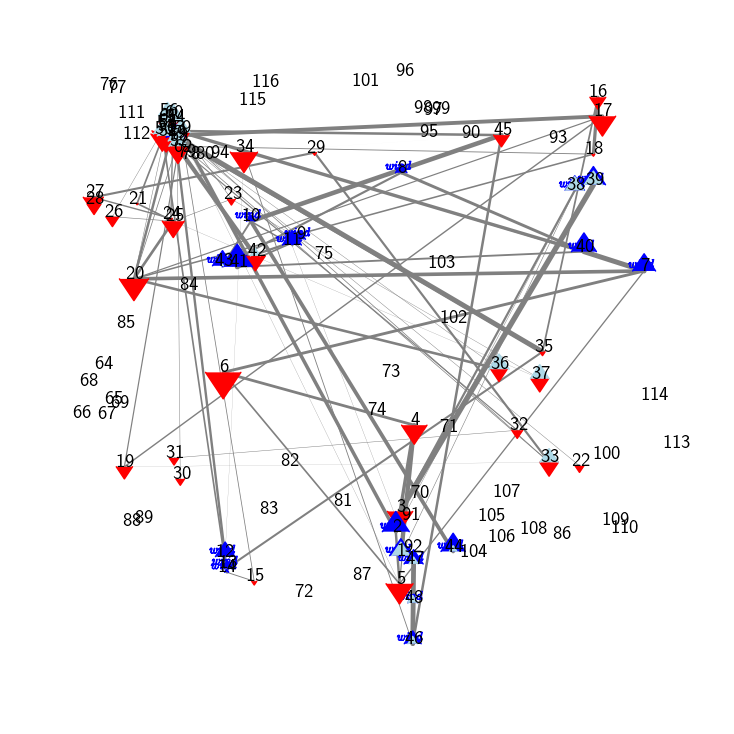

In [111]:
stor = 'Storage'
var = '' # '_WithVariance'
loc_glob = 'local'

t=0
plot_graph('Turkish', coord_Turkish, "20+14", 'NoStorage', var, loc_glob, t=t, case_nr='caseTurkish_dataset', figsize=(10,10), SHOW_NRS=False, LAB=True)
#plot_graph('Turkish', coord_Turkish, "20+14", 'Storage', var, loc_glob, t=t, case_nr='caseTurkish_dataset', figsize=(10,10), SHOW_NRS=False, LAB=False)

## Results Analysis

In [31]:
mat = scipy.io.loadmat('casefiles/'+'results_'+'caseTurkish_dataset'+'_mpc'+'.mat')

In [32]:
# MAT OPF
# 0,0,2 nodes 61x17
# 0,0,3 generators 24x25
# 0,0,4 lines 91x21
# 0,0,5 gen. costs 24x7
mat_bus = mat['mpc'][0][0][2]
mat_gen = mat['mpc'][0][0][3]
mat_branch = mat['mpc'][0][0][4]

In [35]:
# JULIA OPF
file = 'Results/caseTurkish/20+14/ExportedResults/Results_DCsOPF_Storage_local.mat'
mat_results = mat73.loadmat(file)
#mat_results_gen = mat_results['generators']['mean']
#mat_results_stor = mat_results['storages']['mean']
#mat_results_load = mat_results['load']

In [40]:
def extract_Pg_time_t(mat_gen, t=0, baseMVA=100):
    d = mat_gen
    mat_Pg = np.array([[int(el.replace('bus_','')), d[el]] for el in list(d.keys())])
    mat_Pg_t = [(mat_Pg[i][0], mat_Pg[i][1][t]) for i in range(len(mat_Pg))]
    mat_Pg_t.sort(key=lambda tup: tup[0])
    mat_Pg_t_onlyPg = np.array([(mat_Pg_t[i][0], mat_Pg_t[i][1]*baseMVA) for i in range(len(mat_Pg_t))])
    mat_Pg_t_onlyPg[:,0] = mat_Pg_t_onlyPg[:,0].astype(int)
    return mat_Pg_t_onlyPg 

def plot_network_limits_DIFFERENCE(mat_file='results_caseTurkish_dataset_mpc', file_directory='caseTurkish_distributedStorages', file_directory2='caseTurkish_distributedStorages', DCsOPF_file1='Results_DCsOPF_NoStorage_global', DCsOPF_file2='Results_DCsOPF_Storage_global'):

    baseMVA = 100
    t = 6
    
    # load capacities & .mat casefile
    data = 
    df = data['capacity source type (MW)']
    mat = scipy.io.loadmat('casefiles/'+mat_file+'.mat')
    mat_results =  mat73.loadmat(file_directory+"/"+DCsOPF_file1+'.mat')
    mat_results2 =  mat73.loadmat(file_directory+"/"+DCsOPF_file2+'.mat')
    uncertainties = mat_results['uncertainties']
    if 'storages' in mat_results2.keys():
        storages = extract_Pg_time_t(mat_results2['storages']['mean'], 6, 100)[:,0].astype(int)
    else:
        storages = []
    
    # create graph from .mat casefile
    case = ppc.from_mpc('casefiles/'+mat_file+'.mat')
    G = pp.topology.create_nxgraph(case)
    
    # extract buses, generators and branches
    mat_bus = mat['mpc'][0][0][2]
    #mat_gen = mat['mpc'][0][0][3]
    mat_branch = mat['mpc'][0][0][4]
    # NEW RESULTS
    mat_results_gen = mat_results['generators']['mean']
    mat_results_gen2 = mat_results2['generators']['mean']
    
    # relabel indices
    # MATLAB (starts counting at 1) --> Python (starts counting at 0)
    mat_bus[:,0] = mat_bus[:,0].astype(int)-1
    mat_gen[:,0] = mat_gen[:,0].astype(int)-1
    mat_branch[:,[0,1]] = mat_branch[:,[0,1]].astype(int)-1 
    uncertainties = [u-1 for u in uncertainties]
    storages = [s-1 for s in storages]
    
    # ------------ LABELS (node names & nrs) --------------------
    G_nrs = G.copy()
    labels_nrs = {n : n for n in list(G.nodes)}
    G_nrs = nx.relabel_nodes(G_nrs, labels_nrs)
    labels_name = {n : bus_nr_to_dataset_names([n+1])[0] for n in list(G.nodes)}
    G = nx.relabel_nodes(G, labels_name)
    labels_nrs = {n : list(G_nrs.nodes)[i] for i,n in enumerate(list(G.nodes))}

    # ------------ COORDINATES --------------------
    # coordinates (names)
    coordinates_case = dict()
    for n in G.nodes:
        idx = df[df['Substation Nodes']==n].index[0]
        coordinates_case[n] = df.loc[idx, 'Longitude'], df.loc[idx, 'Latitude']
    coordinates_case = {e: coordinates_case[e] for e in list(np.unique(list(coordinates_case.keys())))}
    nx.set_node_attributes(G, coordinates_case, 'coord')
    
    # coordinates (numbers)
    coordinates_case_nrs = dict()
    for n in G_nrs.nodes:
        coordinates_case_nrs[n] = df.loc[n, 'Longitude'], df.loc[n, 'Latitude']
    coordinates_case_nrs = {e: coordinates_case_nrs[e] for e in list(np.unique(list(coordinates_case_nrs.keys())))}
    nx.set_node_attributes(G_nrs, coordinates_case_nrs, 'coord')

    # ------------ LOADS --------------------
    #loads = mat_bus[:,2]
    loads = extract_Pg_time_t(mat_results['load'], t, baseMVA)[:,1] * (-1)
    loads_labels = {name : loads[nr].astype(int) for name,nr in zip(list(G.nodes), list(G_nrs.nodes))}
    node_size_loads = list(loads_labels.values())
    pos_labels = {k : (v[0]+0.2,v[1]+0.2) for k,v in coordinates_case.items()}
    pos_labels_nrs = {k : (v[0]-0.2,v[1]-0.2) for k,v in coordinates_case.items()}
    
    # ------------ GENERATION --------------------
    
    # generation
    gen_diff = np.zeros(len(mat_bus))
    gen_bus_nrs = extract_Pg_time_t(mat_results_gen, t, baseMVA)[:,0].astype(int) - 1 # JULIA -> PYTHON
    gen_diff[gen_bus_nrs] = abs(extract_Pg_time_t(mat_results_gen, t, baseMVA)[:,1] - extract_Pg_time_t(mat_results_gen2, t, baseMVA)[:,1])
    gen_labels = {nr : gen_diff[nr] for nr in list(G_nrs.nodes)}
    node_size_gen = list(gen_labels.values())

    # ------------ LINE FLOWs & CAPACITIES --------------------
    G_lines = nx.Graph()
    G_lines.add_nodes_from(G.nodes)
    
    # line flow
    mat_buses = mat_branch
    line_flow_diff = abs(extract_Pg_time_t(mat_results['lines']['mean'], t)[:,1]) - abs(extract_Pg_time_t(mat_results2['lines']['mean'], t)[:,1])
    for i,e in enumerate(G.edges):
        G_lines.add_edge(e[0],e[1],weight=line_flow_diff[i])
        
    edge_color_line_flow_diff = ['red' if e>0 else 'lime' for e in line_flow_diff]
        
    rateA = mat_branch[:,5] # rate A
    
    # ------------ STORAGES & UNCERTAINTIES --------------------
    uncertainty_labels = DF(np.zeros(len(mat_bus)), index=list(G_nrs.nodes),columns=['0'])
    uncertainty_labels.loc[uncertainties] = 100
    storage_labels = DF(np.zeros(len(mat_bus)), index=list(G_nrs.nodes),columns=['0'])
    storage_labels.loc[storages] = 200

    # ============== PLOT ======================================
    a = 3
    b = 1.5
    c = 0.1
    plt.figure(figsize=(23,12)) 
    nx.draw(G, coordinates_case, node_color='white', with_labels=False, font_size=10, edge_color='white', font_color='k', node_size=1)
    # labels
    #nx.draw_networkx_labels(G, pos_labels, labels=loads_labels, font_color='gray', font_size=20)
    #nx.draw_networkx_labels(G, pos_labels_nrs, labels=labels_nrs)
    # edges
    nx.draw_networkx_edges(G, coordinates_case, node_size=0, edge_color='lightsteelblue', width=rateA*c, alpha=0.2)
    nx.draw_networkx_edges(G, coordinates_case, edge_color=edge_color_line_flow_diff, width=line_flow_diff * c, alpha=0.7)
    # nodes
    #nx.draw_networkx_nodes(G, coordinates_case, node_color='khaki', node_size=np.multiply(node_size_loads,a), node_shape=8) # 8 = triangle left
    nx.draw_networkx_nodes(G, coordinates_case, node_size=np.multiply(storage_labels['0'],a), node_color='lightsteelblue', node_shape='o', alpha=0.5)
    nx.draw_networkx_nodes(G, coordinates_case, node_size=np.multiply(uncertainty_labels['0'],b), node_color='lightsteelblue', node_shape='o', alpha=0.5) # '$unc.$'
    nx.draw_networkx_nodes(G, coordinates_case, node_color='black', node_size=np.multiply(node_size_gen,a), node_shape=9) # 9 = triangle right
    #plt.title('Matpower results '+name)
    plt.savefig(PATH_SAVE + '/'+file_directory+"_"+DCsOPF_file1+'-'+DCsOPF_file2+'_OPF_results_DIFFERENCE')
    plt.show()

In [80]:
mat_file='results_caseTurkish_dataset_mpc'
file_directory='caseTurkish_distributedStorages'
file_directory2='caseTurkish_StoragesCloseToLoad'
DCsOPF_file1, DCsOPF_file2 = 'Results_DCsOPF_NoStorage_local', 'Results_DCsOPF_Storage_local'
DCsOPF_file1, DCsOPF_file2 = 'Results_DCsOPF_NoStorage_global', 'Results_DCsOPF_Storage_global'
DCsOPF_file1, DCsOPF_file2 = 'Results_DCsOPF_Storage_local', 'Results_DCsOPF_Storage_local'
#DCsOPF_file1, DCsOPF_file2 = 'Results_DCsOPF_Storage_global_withVariance', 'Results_DCsOPF_Storage_local_withVariance'
plot_network_limits_DIFFERENCE(mat_file, file_directory, file_directory2, DCsOPF_file1, DCsOPF_file2)

AssertionError: graphics/DCsOPF_results/Turkish_firstPaperDraft/caseTurkish_distributedStorages/Results_DCsOPF_Storage_local.mat does not exist

In [63]:
mat_file='results_caseTurkish_dataset_mpc'
file_directory='caseTurkish_distributedStorages'
file_directory2='caseTurkish_StoragesCloseToLoad'
DCsOPF_file1, DCsOPF_file2 = 'Results_DCsOPF_NoStorage_local', 'Results_DCsOPF_Storage_local'
DCsOPF_file1, DCsOPF_file2 = 'Results_DCsOPF_NoStorage_global', 'Results_DCsOPF_Storage_global'
DCsOPF_file1, DCsOPF_file2 = 'Results_DCsOPF_Storage_local', 'Results_DCsOPF_Storage_local'
#DCsOPF_file1, DCsOPF_file2 = 'Results_DCsOPF_Storage_global_withVariance', 'Results_DCsOPF_Storage_local_withVariance'
plot_network_limits_DIFFERENCE(mat_file, file_directory, file_directory2, DCsOPF_file1, DCsOPF_file2)

AssertionError: graphics/DCsOPF_results/Turkish_firstPaperDraft/caseTurkish_distributedStorages/Results_DCsOPF_Storage_local.mat does not exist

In [279]:
def extract_Pg_time_t(mat_gen, t=0, baseMVA=100):
    d = mat_gen
    mat_Pg = np.array([[int(el.replace('bus_','')), d[el]] for el in list(d.keys())])
    mat_Pg_t = [(mat_Pg[i][0], mat_Pg[i][1][t]) for i in range(len(mat_Pg))]
    mat_Pg_t.sort(key=lambda tup: tup[0])
    mat_Pg_t_onlyPg = np.array([(mat_Pg_t[i][0], mat_Pg_t[i][1]*baseMVA) for i in range(len(mat_Pg_t))])
    mat_Pg_t_onlyPg[:,0] = mat_Pg_t_onlyPg[:,0].astype(int)
    return mat_Pg_t_onlyPg 

def extract_results(mat_file, kind, t=6, mean_var="mean"):
    assert kind in mat_file.keys(), "Wrong kind."
    d = mat_file[kind][mean_var]
    return {int(bus.split("_")[1]) : ts[t] for bus, ts in d.items()}

def bus_nr_to_dataset_names(nr):
    return data['Substation Nodes'][nr]

def plot_network_limits_RESULTS_FROM_JULIA(df, mat_file='results_caseTurkish_dataset_mpc', file_directory='caseTurkish_distributedStorages', DCsOPF_file='Results_DCsOPF_NoStorage_global'):

    baseMVA = 100
    t = 6

    # .mat file
    mat           = scipy.io.loadmat('casefiles/'+mat_file+'.mat')
    mat_results   = mat73.loadmat('Results/'+file_directory+"/"+DCsOPF_file+'.mat')
    uncertainties = mat_results['uncertainties']
    if 'storages' in mat_results.keys():
        storages = extract_Pg_time_t(mat_results['storages']['mean'], 6, 100)[:,0].astype(int)
    else:
        storages = []

    case = ppc.from_mpc('casefiles/'+mat_file+'.mat')
    G    = pp.topology.create_nxgraph(case)

    # buses, generators and branches
    mat_bus         = mat['mpc'][0][0][2]
    # mat_gen         = mat['mpc'][0][0][3]
    mat_branch      = mat['mpc'][0][0][4]
    mat_results_gen = mat_results['generators']['mean'] # new

    # relabel indices
    # MATLAB (starts counting at 1) --> Python (starts counting at 0)
    uncertainties       = [u-1 for u in uncertainties]
    storages            = [s-1 for s in storages]
    mat_bus[:,0]        = mat_bus[:,0].astype(int)-1
    mat_gen[:,0]        = mat_gen[:,0].astype(int)-1
    mat_branch[:,[0,1]] = mat_branch[:,[0,1]].astype(int)-1 

    # ------------ LABELS (node names & nrs) --------------------
    G_nrs = G.copy()
    labels_nrs = {n : n for n in list(G.nodes)}
    G_nrs = nx.relabel_nodes(G_nrs, labels_nrs)
    labels_name = {n : bus_nr_to_dataset_names(n+1) for n in list(G.nodes)}
    G = nx.relabel_nodes(G, labels_name)
    labels_nrs = {n : list(G_nrs.nodes)[i] for i,n in enumerate(list(G.nodes))}

    coordinates_case = dict()
    for n in G.nodes:
        idx = df[df['Substation Nodes']==n].index[0]
        coordinates_case[n] = df.loc[idx, 'Longitude'], df.loc[idx, 'Latitude']
    coordinates_case = {e: coordinates_case[e] for e in list(np.unique(list(coordinates_case.keys())))}
    nx.set_node_attributes(G, coordinates_case, 'coord')

    # coordinates (numbers)
    coordinates_case_nrs = dict()
    for n in G_nrs.nodes:
        coordinates_case_nrs[n] = df.loc[n, 'Longitude'], df.loc[n, 'Latitude']
    coordinates_case_nrs = {e: coordinates_case_nrs[e] for e in list(np.unique(list(coordinates_case_nrs.keys())))}
    nx.set_node_attributes(G_nrs, coordinates_case_nrs, 'coord')

    # ------------ LOADS --------------------
    #loads = mat_bus[:,2]
    loads = extract_results(mat_results, 'load', t)
    loads_labels = {name : loads[nr+1].astype(int) for name,nr in zip(list(G.nodes), list(G_nrs.nodes))}
    node_size_loads = list(loads_labels.values())
    pos_labels = {k : (v[0]+0.2,v[1]+0.2) for k,v in coordinates_case.items()}
    pos_labels_nrs = {k : (v[0]-0.2,v[1]-0.2) for k,v in coordinates_case.items()}


    gen = np.zeros(len(mat_bus))
    #gen[mat_gen[:,0].astype(int)] = mat_gen[:,1]
    gen_bus_nrs = extract_results(mat_results, 'generators', t) # JULIA -> PYTHON
    gen_bus_nrs_ = {k-1 : v for k,v in gen_bus_nrs.items()}
    gen[list(gen_bus_nrs_.keys())] = list(gen_bus_nrs.values())
    gen_labels = {nr : gen[nr] for nr in list(G_nrs.nodes)}
    node_size_gen = list(gen_labels.values())

    G_lines = nx.Graph()
    G_lines.add_nodes_from(G.nodes)

    # line flow
    c = 0.03
    mat_buses = mat_branch
    #line_flow = mat_buses[:,15]*c # flow fbus to tbus
    line_flow = extract_results(mat_results, 'lines', t)
    for i,e in enumerate(G.edges):
        G_lines.add_edge(e[0],e[1],weight=line_flow[e[2][1]+1])
    l = np.zeros(len(line_flow))
    for k,v in line_flow.items():
        l[k-1] = v
    line_flow = l

    # line capacities
    rateA = mat_branch[:,5] # rate A
    max_flow_ = [line_flow[i] > rateA[i]*0.98 for i in range(len(rateA))]
    max_flow = ['midnightblue' if e else 'royalblue' for e in max_flow_]

    # ------------ STORAGES & UNCERTAINTIES --------------------
    uncertainty_labels = DF(np.zeros(len(mat_bus)), index=list(G_nrs.nodes),columns=['0'])
    uncertainty_labels.loc[uncertainties] = 100
    storage_labels = DF(np.zeros(len(mat_bus)), index=list(G_nrs.nodes),columns=['0'])
    storage_labels.loc[storages] = 200
    
    print(coordinates_case)

    a = 1.5
    plt.figure(figsize=(23,12)) 
    nx.draw(G, coordinates_case, node_color='white', with_labels=False, font_size=10, edge_color='white', font_color='k', node_size=1)
    # labels
    #nx.draw_networkx_labels(G, pos_labels, labels=loads_labels, font_color='gray', font_size=20)
    #nx.draw_networkx_labels(G, pos_labels_nrs, labels=labels_nrs)
    # edges
    nx.draw_networkx_edges(G, coordinates_case, node_size=0, edge_color='lightsteelblue', width=rateA*c, alpha=0.7)
    nx.draw_networkx_edges(G, coordinates_case, edge_color=max_flow, width=line_flow * c, alpha=0.7)
    # nodes
    nx.draw_networkx_nodes(G, coordinates_case, node_color='khaki', node_size=np.multiply(node_size_loads,a), node_shape=8) # 8 = triangle left
    nx.draw_networkx_nodes(G, coordinates_case, node_color=max_gen, node_size=np.multiply(node_size_gen,a), node_shape=9) # 9 = triangle right
    nx.draw_networkx_nodes(G, coordinates_case, node_size=np.multiply(storage_labels['0'],a), node_color='mediumaquamarine', node_shape='o')
    nx.draw_networkx_nodes(G, coordinates_case, node_size=uncertainty_labels['0'], node_color='red', node_shape='o') # '$unc.$'
    #plt.title('Matpower results '+name)
    plt.savefig('Results/'+file_directory+"_"+DCsOPF_file+'_OPF_results')
    plt.show()

{'ADANA_Imamoglu': (35.67284, 37.258751), 'ADANA_Kozan': (35.8, 37.45), 'ADANA_Tufanbeyli': (36.2223985, 38.2646417), 'ADANA_Yumurtalik': (35.7833333, 36.7666667), 'AFYONKARAHISAR_Merkez': (30.54034, 38.76376), 'AGRI_Merkez': (43.0566667, 39.7216667), 'AMASYA_Merkez': (35.8333333, 40.65), 'ANKARA_Kecioren': (32.831015, 40.0210623), 'ANKARA_Nallihan': (31.359949, 40.191601), 'ANKARA_Sincan': (32.584229, 39.966751), 'ANTALYA_Dosemealti': (30.5984143, 37.0229292), 'ANTALYA_Kepez': (30.672219, 36.918648), 'ANTALYA_Konyaalti': (30.641946, 36.875598), 'ANTALYA_Manavgat': (31.46286, 36.790081), 'ARTVIN_Borcka': (41.68, 41.3625), 'ARTVIN_Merkez': (41.8166667, 41.1833333), 'ARTVIN_Yusufeli': (41.5486163, 40.8253871), 'AYDIN_Germencik': (27.60181, 37.87207), 'BALIKESIR_Altieylul': (27.885289, 39.646791), 'BALIKESIR_Bandirma': (27.979227, 40.35946), 'BATMAN_Merkez': (41.13509, 37.881168), 'BOLU_Goynuk': (30.7838403, 40.4003841), 'BURSA_Nilufer': (28.984763, 40.217761), 'BURSA_Osmangazi': (29.0547

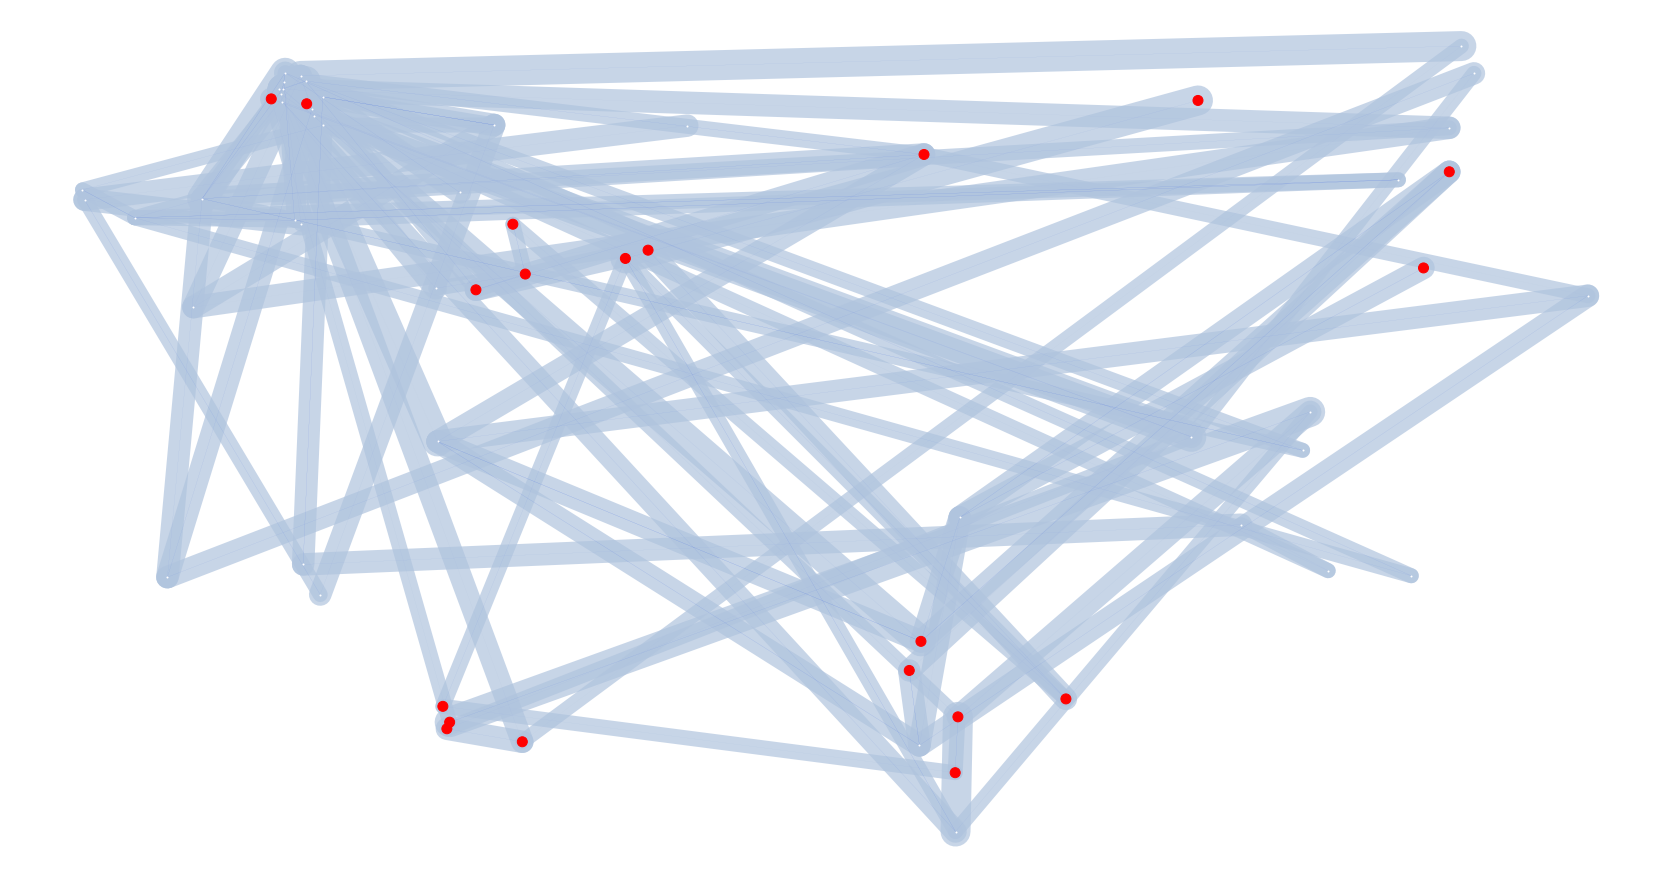

In [280]:
mat_file='results_caseTurkish_dataset_mpc'
file_directory='caseTurkish/20+14/ExportedResults'
DCsOPF_file='Results_DCsOPF_NoStorage_local'
#DCsOPF_file='Results_DCsOPF_NoStorage_global'
#DCsOPF_file='Results_DCsOPF_Storage_local'
#DCsOPF_file='Results_DCsOPF_Storage_global'
#DCsOPF_file='Results_DCsOPF_Storage_local_withVariance'
#DCsOPF_file='Results_DCsOPF_Storage_global_withVariance'
plot_network_limits_RESULTS_FROM_JULIA(data, mat_file, file_directory, DCsOPF_file)

In [66]:
def plot_network_limits(mat_file='results_caseTurkish_dataset_mpc', name='caseTurkish_dataset', uncertainties=[59,47,55,41,52], storages=[4,6,7,8]):

    # load capacities & .mat casefile
    df = data['capacity source type (MW)']
    mat = scipy.io.loadmat('casefiles/'+mat_file+'.mat')
    
    # create graph from .mat casefile
    case = ppc.from_mpc('casefiles/'+mat_file+'.mat')
    G = pp.topology.create_nxgraph(case)
    
    # extract buses, generators and branches
    mat_bus = mat['mpc'][0][0][2]
    mat_gen = mat['mpc'][0][0][3]
    mat_branch = mat['mpc'][0][0][4]
    
    # relabel indices
    # MATLAB (starts counting at 1) --> Python (starts counting at 0)
    mat_bus[:,0] = mat_bus[:,0].astype(int)-1
    mat_gen[:,0] = mat_gen[:,0].astype(int)-1
    mat_branch[:,[0,1]] = mat_branch[:,[0,1]].astype(int)-1 
    uncertainties = [u-1 for u in uncertainties]
    storages = [s-1 for s in storages]
    
    # ------------ LABELS (node names & nrs) --------------------
    G_nrs = G.copy()
    labels_nrs = {n : n for n in list(G.nodes)}
    G_nrs = nx.relabel_nodes(G_nrs, labels_nrs)
    labels_name = {n : bus_nr_to_dataset_names([n+1])[0] for n in list(G.nodes)}
    G = nx.relabel_nodes(G, labels_name)
    labels_nrs = {n : list(G_nrs.nodes)[i] for i,n in enumerate(list(G.nodes))}

    # ------------ COORDINATES --------------------
    # coordinates (names)
    coordinates_case = dict()
    for n in G.nodes:
        idx = df[df['Substation Nodes']==n].index[0]
        coordinates_case[n] = df.loc[idx, 'Longitude'], df.loc[idx, 'Latitude']
    coordinates_case = {e: coordinates_case[e] for e in list(np.unique(list(coordinates_case.keys())))}
    nx.set_node_attributes(G, coordinates_case, 'coord')
    
    # coordinates (numbers)
    coordinates_case_nrs = dict()
    for n in G_nrs.nodes:
        coordinates_case_nrs[n] = df.loc[n, 'Longitude'], df.loc[n, 'Latitude']
    coordinates_case_nrs = {e: coordinates_case_nrs[e] for e in list(np.unique(list(coordinates_case_nrs.keys())))}
    nx.set_node_attributes(G_nrs, coordinates_case_nrs, 'coord')

    # ------------ LOADS --------------------
    loads = mat_bus[:,2]
    loads_labels = {name : loads[nr].astype(int) for name,nr in zip(list(G.nodes), list(G_nrs.nodes))}
    node_size_loads = list(loads_labels.values())
    pos_labels = {k : (v[0]+0.2,v[1]+0.2) for k,v in coordinates_case.items()}
    pos_labels_nrs = {k : (v[0]-0.2,v[1]-0.2) for k,v in coordinates_case.items()}

    # ------------ GENERATION --------------------
    
    # generation
    gen = np.zeros(len(mat_bus))
    gen[mat_gen[:,0].astype(int)] = mat_gen[:,1]
    gen_labels = {nr : gen[nr] for nr in list(G_nrs.nodes)}
    node_size_gen = list(gen_labels.values())
    
    # max gen
    color1, color2 = 'orange', 'darkorange'
    gen_abs = mat_gen[:,1]
    gen_cap = mat_gen[:,8]
    max_gen = []
    j = 0
    for i in range(len(mat_bus)):
        if i in mat_gen[:,0].astype(int):
            if gen_abs[j] > gen_cap[j]*0.98:
                max_gen.append(color2)
            else:
                max_gen.append(color1)
            j = j+1
        else:
            max_gen.append(color1)
    max_gen

    # ------------ LINE FLOWs & CAPACITIES --------------------
    G_lines = nx.Graph()
    G_lines.add_nodes_from(G.nodes)
    
    # line flow
    c = 0.03
    mat_buses = mat_branch
    line_flow = mat_buses[:,15]*c # flow fbus to tbus
    for i,e in enumerate(G.edges):
        G_lines.add_edge(e[0],e[1],weight=line_flow[i])
        
    # line capacities
    rateA = mat_branch[:,5] # rate A
    max_flow_ = [line_flow[i] > rateA[i]*0.98 for i in range(len(rateA))]
    max_flow = ['midnightblue' if e else 'royalblue' for e in max_flow_]
    
    # ------------ STORAGES & UNCERTAINTIES --------------------
    uncertainty_labels = DF(np.zeros(len(mat_bus)), index=list(G_nrs.nodes),columns=['0'])
    uncertainty_labels.loc[uncertainties] = 50
    storage_labels = DF(np.zeros(len(mat_bus)), index=list(G_nrs.nodes),columns=['0'])
    storage_labels.loc[storages] = 200

    # ============== PLOT ======================================
    plt.figure(figsize=(23,12)) 
    nx.draw(G, coordinates_case, node_color='lavender', with_labels=True, font_size=10, edge_color='lavender', font_color='k', node_size=1)
    #nx.draw_networkx_labels(G, pos_labels, labels=loads_labels, font_color='gray', font_size=20)
    nx.draw_networkx_labels(G, pos_labels_nrs, labels=labels_nrs)
    nx.draw_networkx_edges(G, coordinates_case, node_size=0, edge_color='lightsteelblue', width=rateA*c, alpha = 0.7)
    nx.draw_networkx_edges(G, coordinates_case, edge_color=max_flow, width=line_flow, alpha=0.7)
    nx.draw_networkx_nodes(G, coordinates_case, node_color='khaki', node_size=node_size_loads, node_shape=8) # 8 = triangle left
    nx.draw_networkx_nodes(G, coordinates_case, node_color=max_gen, node_size=node_size_gen, node_shape=9) # 9 = triangle right
    nx.draw_networkx_nodes(G, coordinates_case, node_size=storage_labels['0'], node_color='olive', node_shape='o')
    nx.draw_networkx_nodes(G, coordinates_case, node_size=uncertainty_labels['0'], node_color='white', node_shape='o') # '$unc.$'
    plt.title('Matpower results '+name)
    plt.savefig(PATH_SAVE + '/'+name+'_OPF_results_loads_gen')
    plt.show()

In [67]:
# load, gen capacity from dataset
name='caseTurkish_dataset'
mat_file='results_'+name+'_mpc'
plot_network_limits(mat_file, name, uncertainties=[51, 45, 20, 17, 50, 41], storages=[2,3,6,20])

NameError: name 'bus_nr_to_dataset_names' is not defined

In [68]:
# laod, gen capacity from paper
name='caseTurkish_paper'
mat_file='results_'+name+'_mpc'
plot_network_limits(mat_file, name)

NameError: name 'bus_nr_to_dataset_names' is not defined